<a href="https://colab.research.google.com/github/Leolai80047/106-OS-homework1/blob/master/tensorflow_predict_12_29(177_feature_always_feed_newest_data_for_11_months)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pymysql
!pip install funcy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from datetime import datetime, timedelta
import pymysql as pms
import sys
import os
import random as rn
import calendar
import heapq
from funcy.seqs import pairwise

In [0]:
# Functions

# reverse the data of argument
def reverseData(data):
    data = data[::-1]
    return data

def getRound(data, decimals = 3):
    return np.around(data, decimals)

## given two curve a, b, then return the inversection point of two curves
def FindTheBuyPoint(a, b, mode):
    if(mode == "rsi_1"):
        buyPoint = np.argwhere(np.diff(np.sign(a - 20)) > 0).reshape(-1) + 0
    else:
        buyPoint = np.argwhere(np.diff(np.sign(a - b)) > 0).reshape(-1) + 0
    return buyPoint

def FindTheSellPoint(a, b, mode):
    if(mode == "rsi_1"):
        sellPoint = np.argwhere(np.diff(np.sign(a - 80)) < 0).reshape(-1) + 0
    else:
        sellPoint = np.argwhere(np.diff(np.sign(a - b)) < 0).reshape(-1) + 0
    return sellPoint

def GetDataFromDB(ip, userName, psw, tableName, sql):
    try:
        db = pms.connect(ip, userName, psw, tableName)
        #create a cursor
        cursor = db.cursor(pms.cursors.DictCursor)
        results = []
        try:
            cursor.execute(sql)
            results = cursor.fetchall()
        except:
            print ("Error: unable to fetch data from DB")
        db.close()
        return results
    except:
        print ("Error: unable to connect to DB")
    
def DeterminedStatus(indicatorResultFast, indicatorResultSlow, result):
    longShortIndex = [i for i in range(len(result)) if result[i] == 1 or result[i] == -1]
    for i in range(len(longShortIndex) - 1):
        begin = longShortIndex[i]
        end = longShortIndex[i + 1]
        # find the series between begin and end
        selectedIndicatorResultFast = indicatorResultFast[begin + 1:end]
        if len(selectedIndicatorResultFast) == 0:
            continue
        selectedIndicatorResultSlow = indicatorResultSlow[begin + 1:end]
        if len(selectedIndicatorResultSlow) == 0:
            continue
        # find the distance of every elements
        distanceSeries = [abs(x1 - x2) for (x1, x2) in zip(selectedIndicatorResultFast, selectedIndicatorResultSlow)]
        
        # normalize all distance to [0, 1]
        maxDistance = max(distanceSeries)
        distanceSeries = [i * 2 / maxDistance for i in distanceSeries]
        
        # find the index of largest distance
        largestIndex = begin + 1 + distanceSeries.index(2)
        result[largestIndex] = 0
        firstNumber, lastNumber = result[begin], result[end]
        for j in range(begin + 1, end):
            if j != largestIndex:
                if firstNumber == 1:
                    result[j] = firstNumber - distanceSeries[j - (begin + 1)]
                else:
                    result[j] = firstNumber + distanceSeries[j - (begin + 1)]
    # TO deal w/ the records which are not between long point and short point
    begin = longShortIndex[-1]
    end = len(indicatorResultFast)
    targetListF = indicatorResultFast[begin + 1:end]
    targetListS = indicatorResultSlow[begin + 1:end]
    # find the distance of every elements
    distanceSeries = [abs(x1 - x2) for (x1, x2) in zip(targetListF, targetListS)]
    print ('distanceSeries')
    print (distanceSeries)
    # normalize all distance to [0, 1]
    maxDistance = max(distanceSeries)
    distanceSeries = [i * 2 / maxDistance for i in distanceSeries]
    print ('modified distanceSeries')
    print (distanceSeries)
    # find the index of largest distance
    largestIndex = begin + 1 + distanceSeries.index(2)
    result[largestIndex] = 0
    firstNumber, lastNumber = result[begin], result[end - 1]
    for i in range(begin + 1, end):
        if i != largestIndex:
            if firstNumber == 1:
                result[i] = firstNumber - distanceSeries[i - (begin + 1)]
            else:
                result[i] = firstNumber + distanceSeries[i - (begin + 1)]
    return result

def getFeaturesCrossIndicators(historicalPrices):
    indicatorNameList = [
        'sma5',
        'sma10',
        'sma20',
        'sma60',
        'sma120',
        'sma240'
    ]
    indicators = {}
    indicators['sma5'] = SMA(historicalPrices['CLOSE'], 5)
    indicators['sma10'] = SMA(historicalPrices['CLOSE'], 10)
    indicators['sma20'] = SMA(historicalPrices['CLOSE'], 20)
    indicators['sma60'] = SMA(historicalPrices['CLOSE'], 60)
    indicators['sma120'] = SMA(historicalPrices['CLOSE'], 120)
    indicators['sma240'] = SMA(historicalPrices['CLOSE'], 240)
    indicators['bias5'] = Bias(historicalPrices['CLOSE'], 5)
    indicators['bias10'] = Bias(historicalPrices['CLOSE'], 10)
    indicators['bias20'] = Bias(historicalPrices['CLOSE'], 20)
    indicators['bias60'] = Bias(historicalPrices['CLOSE'], 60)
    indicators['bias120'] = Bias(historicalPrices['CLOSE'], 120)
    indicators['bias240'] = Bias(historicalPrices['CLOSE'], 240)
    indicators['rsi5'] = RSI(historicalPrices['CLOSE'], 5)
    indicators['rsi14'] = RSI(historicalPrices['CLOSE'], 14)
    kd = KD(historicalPrices['CLOSE'], historicalPrices['HIGH'], historicalPrices['LOW'])
    indicators['k'] = kd['K9']
    indicators['d'] = kd['D9']
    macd = MACD(historicalPrices['CLOSE'], historicalPrices['HIGH'], historicalPrices['LOW'], [12, 26, 9])
    indicators['dif'] = macd['dif']
    indicators['dem'] = macd['dem']
    
    crossOverTwoIndicators = {}
    for i in range(len(indicatorNameList) - 1):
        for j in range(i + 1, len(indicatorNameList)):
            crossOverTwoIndicators[indicatorNameList[i] + '-' + indicatorNameList[j]] = indicators[indicatorNameList[i]] - indicators[indicatorNameList[j]]
    crossOverTwoIndicators['sma5-close'] = indicators['sma5'] - historicalPrices['CLOSE']
    crossOverTwoIndicators['sma10-close'] = indicators['sma10'] - historicalPrices['CLOSE']
    crossOverTwoIndicators['sma20-close'] = indicators['sma20'] - historicalPrices['CLOSE']
    crossOverTwoIndicators['sma60-close'] = indicators['sma60'] - historicalPrices['CLOSE']
    crossOverTwoIndicators['sma120-close'] = indicators['sma120'] - historicalPrices['CLOSE']
    crossOverTwoIndicators['sma240-close'] = indicators['sma240'] - historicalPrices['CLOSE']
    
    indicatorNameList = [
        'bias5',
        'bias10',
        'bias20',
        'bias60',
        'bias120',
        'bias240'
    ]
    for indicatorName in indicatorNameList:
        for index in range(1,11):
            crossOverTwoIndicators['{indicatorName}-({num}%)'.format(indicatorName = indicatorName, num = index)] = indicators[indicatorName] - index
            crossOverTwoIndicators['{indicatorName}-(-{num}%)'.format(indicatorName = indicatorName, num = index)] = indicators[indicatorName] + index
    
    crossOverTwoIndicators['rsi5-30'] = indicators['rsi5'] - pd.Series([30 for i in range(len(indicators['rsi5']))])
    crossOverTwoIndicators['rsi5-70'] = indicators['rsi5'] - pd.Series([70 for i in range(len(indicators['rsi5']))])
    crossOverTwoIndicators['rsi5-20'] = indicators['rsi5'] - pd.Series([20 for i in range(len(indicators['rsi5']))])
    crossOverTwoIndicators['rsi5-80'] = indicators['rsi5'] - pd.Series([80 for i in range(len(indicators['rsi5']))])
    crossOverTwoIndicators['rsi14-30'] = indicators['rsi14'] - pd.Series([30 for i in range(len(indicators['rsi14']))])
    crossOverTwoIndicators['rsi14-70'] = indicators['rsi14'] - pd.Series([70 for i in range(len(indicators['rsi14']))])
    crossOverTwoIndicators['rsi14-20'] = indicators['rsi14'] - pd.Series([20 for i in range(len(indicators['rsi14']))])
    crossOverTwoIndicators['rsi14-80'] = indicators['rsi14'] - pd.Series([80 for i in range(len(indicators['rsi14']))])
    crossOverTwoIndicators['rsi5-rsi14'] = indicators['rsi5'] - indicators['rsi14']
    
    crossOverTwoIndicators['k-d'] = indicators['k'] - indicators['d']
    crossOverTwoIndicators['k-30'] = indicators['k'] - pd.Series([30 for i in range(len(indicators['rsi5']))])
    crossOverTwoIndicators['k-70'] = indicators['k'] - pd.Series([70 for i in range(len(indicators['rsi5']))])
    crossOverTwoIndicators['k-20'] = indicators['k'] - pd.Series([20 for i in range(len(indicators['rsi5']))])
    crossOverTwoIndicators['k-80'] = indicators['k'] - pd.Series([80 for i in range(len(indicators['rsi5']))])
    
    crossOverTwoIndicators['dif-dem'] = indicators['dif'] - indicators['dem']
    return pd.DataFrame(crossOverTwoIndicators)

def get_text_analysis_features(text_analysis_data, idea_data, crypto_type):
    if not isinstance(text_analysis_data, dict) or not isinstance(idea_data, list):
        raise TypeError
    start_time = datetime.combine(idea_data[0]['created_time'].date(), datetime.min.time()) + timedelta(days=1)
    end_time = datetime.strptime("20181130", "%Y%m%d")
    text_analysis_features = pd.DataFrame(index=[start_time + timedelta(days=i) for i in range((end_time - start_time).days + 1)])
    empty_column = [0 for i in range(len(text_analysis_features.index))]
    total_weight = 0
    for user_name in text_analysis_data.keys():
        user_id = text_analysis_data[user_name]['id']
        total_weight += text_analysis_data[user_name]['accuracy_so_far']
        selected_ideas = [idea for idea in idea_data if idea['author']==user_id]
        text_analysis_features[user_name] = pd.Series(empty_column, index=text_analysis_features.index)
        for idea in pairwise(selected_ideas):
            start_time_of_prediction = datetime.combine(idea[0]['created_time'].date(), datetime.min.time()) + timedelta(days=1)
            end_time_of_prediction = datetime.combine(idea[-1]['created_time'].date(), datetime.min.time())
            duration_of_prediction = (end_time_of_prediction - start_time_of_prediction).days
            prediction=1 if idea[0]['label'].lower() == 'long' else -1 if idea[0]['label'].lower() == 'short' else 0 
            for i in range(duration_of_prediction + 1):
                text_analysis_features[user_name][start_time_of_prediction + timedelta(days=i)] = prediction
    text_analysis_features['total_user'] = pd.Series(empty_column, index=text_analysis_features.index)
    
    for i in text_analysis_features.index.to_pydatetime():
        for user in text_analysis_features.columns.values:
            if user != 'total_user':
                text_analysis_features.at[i.strftime('%Y-%m-%d'), 'total_user'] = text_analysis_features['total_user'][i.strftime('%Y-%m-%d')] + text_analysis_features[user][i.strftime('%Y-%m-%d')] * text_analysis_data[user]['accuracy_so_far'] / total_weight
    return text_analysis_features

def get_trade_analysis_features(trade_analysis_data):
    if not isinstance(trade_analysis_data, list):
        raise TypeError
    index = [i['trade_time'] for i in trade_analysis_data]
    trade_analysis_features = pd.DataFrame(index=index)
    for col_name in trade_analysis_data[0].keys():
        if col_name != 'id' and col_name != 'trade_time':
            trade_analysis_features[col_name] = pd.Series([i[col_name] for i in trade_analysis_data], index=index)
    return trade_analysis_features

def SMA(closePrices, period):
    if (type(closePrices) == pd.core.series.Series):
        return closePrices.rolling(window = period).mean()
    else:
        print ("Error: Wrong input, SMA(pandas.core.series.Series, integer)")
        
def EMA(closePrices, period):
    if (type(closePrices) == pd.core.series.Series):
        return closePrices.ewm(span = period, adjust = False).mean()
    else:
        print ("Error: Wrong input, EMA(pandas.core.series.Series, integer)")
        
def RSI(closePrices, period):
    if (type(closePrices) == pd.core.series.Series):
        delta = closePrices.diff()
        up, down = delta.copy(), delta.copy()

        up[up < 0] = 0
        down[down > 0] = 0
        down = abs(down)
        
        Up = SMA(up, period)
        Up = Up.fillna(0)
        for i in range(period,len(Up)):
            Up[i] = getRound((Up[i - 1] * (period - 1) + up[i]) / period)

        Down = SMA(down, period)
        Down = Down.fillna(0)
        for i in range(period,len(Down)):
            Down[i] = getRound((Down[i - 1] * (period - 1) + down[i]) / period)


        rsi = 100 * (Up / (Up + Down))
        rsi = rsi.fillna(0)
        return getRound(rsi, 2)
    else:
        print ("Error: Wrong input, RSI(pandas.core.series.Series, integer)")
        
def MACD(closePrices, highPrices, lowPrices, period = []):
    if (type(closePrices) == pd.core.series.Series and type(highPrices) == pd.core.series.Series and type(lowPrices) == pd.core.series.Series and len(period) == 3):   
        di = (highPrices + lowPrices + 2.0 * closePrices) / 4.0
        ema12 = SMA(di, period[0])
        ema12 = ema12.fillna(0)
        for i in range(period[0] + 1, len(ema12)):
            ema12[i] = (ema12[i - 1] * (period[0] - 1) + di[i] * 2.0) / (period[0] + 1)
    
        ema26 = SMA(di, period[1])
        ema26 = ema26.fillna(0)
        for i in range(period[1] + 1, len(ema26)):
            ema26[i] = (ema26[i - 1] * (period[1] - 1) + di[i] * 2.0) / (period[1] + 1)
    
        dif = ema12 - ema26

        dem = SMA(dif, period[2])
        dem = dem.fillna(0)
        for i in range(period[2] + 1, len(dem)):
            dem[i] = (dem[i - 1] * (period[2] - 1) + dif[i] * 2.0) / (period[2] + 1)
        return {'dif':dif, 'dem':dem}
    else:
        if(type(data) == pd.core.frame.DataFrame):
            print ("Error: Wrong input, MACD(pandas.core.frame.DataFrame, list of integer)")
        elif(len(period) == 3):
            print ("Error: number of content in list do not equal to 3")
            
def KD(closePrices, highPrices, lowPrices, result = {}):
    close = closePrices.copy()
    for i in range(0,9):
        close[i] = 0
    data = pd.DataFrame()
    data['RSV'] = (( closePrices - lowPrices.rolling(window = 9).min()) / (highPrices.rolling(window = 9).max() - lowPrices.rolling(window = 9).min()))
    data['RSV'] = data['RSV'].fillna(0)
    if(not result):
        result = {
            'K9':[0],
            'D9' :[0]
        }
    #calculate everyday's KD
    for i in range(1, len(data.index)):
        K9_value = (1.0/3.0) * data['RSV'][i] + (2.0 / 3.0) * result['K9'][i - 1]
        result['K9'].append(getRound(K9_value, 5))
        D9_value = (2.0/3.0) * result['D9'][i - 1] + (1.0 / 3.0) * result['K9'][i]
        result['D9'].append(getRound(D9_value, 5))
        
    return pd.DataFrame(result)

def Bias(closePrices, period):
    if not isinstance(closePrices, pd.core.series.Series) or not isinstance(period, int):
        print("Undefined type")
        return None
    sma = SMA(closePrices=closePrices, period=period)
    return (closePrices / sma - 1) * 100

In [5]:
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(201)
rn.seed(201)

db = pms.connect("140.118.126.136", "123", "1234567890", "bitfinex",cursorclass=pms.cursors.DictCursor)
cursor = db.cursor()
cursor.execute("select * from BTC_usd order by DATE DESC")
result = cursor.fetchall()
db.close()
btc_data = pd.DataFrame(result)
btc_data = btc_data.assign(DATE=pd.to_datetime(btc_data['DATE']))
btc_data['VOLUME'] = (pd.to_numeric(btc_data['VOLUME'], errors='coerce').fillna(0))
btc_data['VOLUME'] = btc_data['VOLUME'].astype('int64')
btc_data

,CLOSE,DATE,HIGH,LOW,OPEN,VOLUME
0,4214.500,2018-12-20,4299.000,3780.100,3810.000,65871
1,3810.000,2018-12-19,4043.000,3756.000,3780.700,55272
2,3780.800,2018-12-18,3799.900,3546.900,3623.900,29431
3,3625.000,2018-12-17,3744.800,3280.000,3300.100,35727
4,3301.500,2018-12-16,3383.000,3276.200,3282.300,19106
5,3283.400,2018-12-15,3324.200,3215.200,3281.700,17889
6,3281.700,2018-12-14,3395.200,3224.000,3354.300,28559
7,3354.300,2018-12-13,3547.100,3317.000,3535.700,22248
8,3535.600,2018-12-12,3617.400,3415.000,3435.200,20930
9,3435.280,2018-12-11,3551.500,3381.800,3523.200,24048


In [0]:
sql = 'select * from {}.{} where accuracy_so_far <> 0'.format(
        'tradingview',
        'user'
)
text_analysis_data=GetDataFromDB("140.118.126.136", "123", "1234567890", "tradingview", sql)
text_analysis_data={i['user_name']:i for i in text_analysis_data}
sql = 'select * from {}.{} where crypto_type = "{}" order by created_time'.format(
    'tradingview',
    'idea', 
    'btc'
)
idea_data=GetDataFromDB("140.118.126.136", "123", "1234567890", "tradingview", sql)
result = get_text_analysis_features(idea_data=idea_data, text_analysis_data=text_analysis_data, crypto_type='btc')

In [0]:
def add_newcol(btc_data): #新增closeoffhigh和volatolity欄位，增加模型訓練的準確度
    market_info = btc_data #將資料只獲取從2017-01-01之後的內容，存到 market_info
    kwargs = { 'CLOSE_OFF_HIGH': lambda x: 2*(x['HIGH'] - x['CLOSE']) / (x['HIGH'] - x['LOW']) - 1, # 1:收盤接近最低價  -1:收盤接近最高價  
          'VOLATILITY': lambda x: (x['HIGH'] - x['LOW']) / (x['CLOSE'])}  #越趨近0越看好
    market_info = market_info.assign(**kwargs)
    market_info=market_info.drop(["HIGH","LOW","OPEN"],1)
    return market_info

def create_train_input_data(data,window_len,pred_length):
    inputs = [] #將Close,Volume以每筆的第一個資料來作正規化，讓值介於-1,1之間
    target=[]
    if 'VOLUME' in data.columns.tolist():
        target=['CLOSE','VOLUME']
    else:
        target=['CLOSE']
        
    for i in range(len(data)-window_len+pred_length):
        temp_set = data[i:(i+window_len)].copy()
        for column in target:
            temp_set.loc[:, column] = temp_set[column]/temp_set[column].iloc[0] - 1
        inputs.append(temp_set)
    return inputs

def create_output_data(data,window_len):#模型的輸出
    return (data['CLOSE'][window_len:].values / data['CLOSE'][:-window_len].values) - 1

def create_test_input_data(data,window_len):
    inputs = [] 
    temp_set = data[-window_len:].copy()
    inputs.append(temp_set)
    return inputs

def data_to_np(data):#原本資料的型態為dataframe，這裡將型態轉為numpy array，模型的資料是以這種型態為主
    data = [np.array(datas)for datas in data]
    data = np.array(data)
    return data

In [0]:
window_len = 5 
pred_length=1
max_layer=3
all_pred=[]

class LSTMRNN(object):
    def __init__(self,input_size,output_size,batch_size,n_steps,cell_size):
        self.input_size=input_size
        self.output_size=output_size
        self.batch_size=batch_size
        self.n_steps=n_steps
        self.cell_size=cell_size       

    def add_input_layer(self):
        l_in_x=tf.reshape(self.xs,[-1,self.input_size],name="2_2D") #[10,4]
        W_in=self.Weight_variable([self.input_size,self.cell_size]) #[4,16]
        B_in=self.Biases_variable([self.cell_size]) #[16]
        with tf.name_scope('Wx_plus_b'):
            l_in_y=tf.matmul(l_in_x,W_in)+B_in #[10,16]
        l_in_y = tf.nn.tanh(tf.nn.dropout(l_in_y, self.keep_prob,seed=operation_level_seed))
        self.l_in_y=tf.reshape(l_in_y,[-1,self.n_steps,self.cell_size],name='2_3D') #[1,10,16]

    def add_cell(self,cell_seed):
        lstm_cell=tf.contrib.rnn.BasicLSTMCell(self.cell_size,forget_bias=1,state_is_tuple=True)
        #lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=cell_seed,seed=operation_level_seed,variational_recurrent=True,dtype=tf.float32)
        lstm_cell=tf.contrib.rnn.MultiRNNCell([lstm_cell] * num_layers, state_is_tuple=True)
        with tf.name_scope('initial_state'):
            self.cell_initial_state=lstm_cell.zero_state(self.batch_size,dtype=tf.float32)
        self.cell_outputs,self.cell_final_state=tf.nn.dynamic_rnn(lstm_cell,self.l_in_y,initial_state=self.cell_initial_state,time_major=False)

    def add_output_layer(self):
        l_out_x=tf.reshape(self.cell_outputs[-1][-1],[1,self.cell_size])
        W_out=self.Weight_variable([self.cell_size,self.output_size]) #[16,1]
        B_out=self.Biases_variable([self.output_size]) #[1]
        with tf.name_scope('Wx_plus_b'):            
            self.pred = tf.nn.tanh(tf.nn.dropout(self.pred, self.keep_prob,seed=operation_level_seed))


    def Weight_variable(self,shape,name="weight"):
        initializer=tf.random_normal_initializer(mean=0,stddev=1,seed=operation_level_seed)
        return tf.get_variable(shape=shape,initializer=initializer,name=name)
    def Biases_variable(self,shape,name='biases'):
        initializer=tf.constant_initializer(0.1)
        return tf.get_variable(shape=shape,initializer=initializer,name=name)

    def compute_cost(self):
        self.learing_rate = tf.train.exponential_decay(LR,self.global_step,100,0.99,staircase=True) #e
        self.loss=tf.reduce_mean(tf.square(tf.reshape(self.pred, [-1])-tf.reshape(self.ys, [-1])))

    def train_model(self):
        with tf.name_scope('inputs'):
            self.xs=tf.placeholder(tf.float32,[None,self.n_steps,self.input_size],name="xs") #[1,10,4]
            self.ys=tf.placeholder(tf.float32,[self.output_size],name="ys")
            self.keep_prob = tf.placeholder(tf.float32)
            self.global_step = tf.Variable(0,trainable=False) #e
        with tf.variable_scope('in_hidden'):
            self.add_input_layer()
        with tf.variable_scope('LSTM_cell'):    
            self.add_cell(0.75)
        with tf.variable_scope('out_hidden'):
            #self.add_output_layer()
            #fc_1=tf.layers.dense(inputs=tf.reshape(self.cell_outputs[-1][-1],[1,self.cell_size])
            #                          ,units=self.cell_size/2,activation=tf.nn.tanh,use_bias=True)
            self.pred=tf.layers.dense(inputs=tf.reshape(self.cell_outputs[-1][-1],[1,self.cell_size])
                                              ,units=OUTPUTSIZE,activation=tf.nn.leaky_relu,use_bias=True)
        with tf.name_scope('cost'):
            self.compute_cost()
        with tf.name_scope('train'):
            self.train_op=tf.train.AdamOptimizer(self.learing_rate).minimize(self.loss,self.global_step) #e
        sess=tf.Session()
        init=tf.global_variables_initializer()
        saver=tf.train.Saver()
        #writer = tf.summary.FileWriter("logs/", sess.graph)
        sess.run(init)

        for epoch in range(100):
            pred_line=[]
            for i in range(len(LSTM_training_inputs)):
                if epoch==0:
                    feed_dict={self.xs:LSTM_training_inputs[np.newaxis,i],self.ys:LSTM_training_outputs[np.newaxis,i],self.keep_prob:0.75}
                else:
                    feed_dict={self.xs:LSTM_training_inputs[np.newaxis,i],self.ys:LSTM_training_outputs[np.newaxis,i],self.cell_initial_state:state,self.keep_prob:0.75}

                _, cost, state, pred=sess.run([self.train_op, self.loss, self.cell_final_state, self.pred],feed_dict=feed_dict)

            print(epoch+1)
            print('cost: ',cost)


        saver.save(sess, './checkpoint_dir/11_30報告/feature_selection/40_center_feature/{}/~{:%Y-%m-%d}/MyModel'.format(current_layer,current_lastDay+datetime.timedelta(days=day)),global_step=1000)



    def predict_model(self):
        tf.reset_default_graph()
        with tf.name_scope('inputs'):
            self.xs=tf.placeholder(tf.float32,[None,self.n_steps,self.input_size],name="xs")
            self.keep_prob = tf.placeholder(tf.float32)
        with tf.variable_scope('in_hidden'):
            self.add_input_layer()
        with tf.variable_scope('LSTM_cell'):    
            self.add_cell(1)
        with tf.variable_scope('out_hidden'):    
            #self.add_output_layer()
            #fc_1=tf.layers.dense(inputs=tf.reshape(self.cell_outputs[-1][-1],[1,self.cell_size])
            #                          ,units=self.cell_size/2,activation=tf.nn.tanh,use_bias=True)
            self.pred=tf.layers.dense(inputs=tf.reshape(self.cell_outputs[-1][-1],[1,self.cell_size])
                                              ,units=OUTPUTSIZE,activation=tf.nn.leaky_relu,use_bias=True)
        saver=tf.train.Saver(tf.global_variables())
        with tf.Session() as sess:
            new_saver = tf.train.import_meta_graph('./checkpoint_dir/11_30報告/feature_selection/40_center_feature/{}/~{:%Y-%m-%d}/MyModel-1000.meta'.format(current_layer,current_lastDay+datetime.timedelta(days=day)))
            new_saver.restore(sess, tf.train.latest_checkpoint('./checkpoint_dir/11_30報告/feature_selection/40_center_feature/{}/~{:%Y-%m-%d}'.format(current_layer,current_lastDay+datetime.timedelta(days=day))))
            self.test_predict=[]
            for step in range(len(LSTM_test_inputs)):
                prob=sess.run(self.pred,feed_dict={self.xs:LSTM_test_inputs[np.newaxis,step],self.keep_prob:1})
                prob=(prob.reshape([-1])).tolist()
                self.test_predict.extend(prob)
            self.test_predict=np.array(self.test_predict)
        return self.test_predict

    def retrain_model(self):
        tf.reset_default_graph()
        with tf.name_scope('inputs'):
            self.xs=tf.placeholder(tf.float32,[None,self.n_steps,self.input_size],name="xs")
            self.ys=tf.placeholder(tf.float32,[self.output_size],name="ys")
            self.keep_prob = tf.placeholder(tf.float32)
            self.global_step = tf.Variable(0,trainable=False)
        with tf.variable_scope('in_hidden'):
            self.add_input_layer()
        with tf.variable_scope('LSTM_cell'):    
            self.add_cell(0.75)
        with tf.variable_scope('out_hidden'):    
            #self.add_output_layer()
            #fc_1=tf.layers.dense(inputs=tf.reshape(self.cell_outputs[-1][-1],[1,self.cell_size])
            #                          ,units=self.cell_size/2,activation=tf.nn.tanh,use_bias=True)
            self.pred=tf.layers.dense(inputs=tf.reshape(self.cell_outputs[-1][-1],[1,self.cell_size])
                                        ,units=OUTPUTSIZE,activation=tf.nn.leaky_relu,use_bias=True)
        with tf.name_scope('cost'):
            self.compute_cost()
        with tf.name_scope('train'):
            self.train_op=tf.train.AdamOptimizer(self.learing_rate).minimize(self.loss,self.global_step) 
        saver=tf.train.Saver(tf.global_variables())
        with tf.Session() as sess:
            new_saver = tf.train.import_meta_graph('./checkpoint_dir/11_30報告/feature_selection/40_center_feature/{}/~{:%Y-%m-%d}/MyModel-1000.meta'.format(current_layer,current_lastDay+datetime.timedelta(days=day-1)))
            new_saver.restore(sess, tf.train.latest_checkpoint('./checkpoint_dir/11_30報告/feature_selection/40_center_feature/{}/~{:%Y-%m-%d}'.format(current_layer,current_lastDay+datetime.timedelta(days=day-1))))
            for epoch in range(100):
                pred_line=[]
                for i in range(len(LSTM_training_inputs)):
                    if epoch==0:
                        feed_dict={self.xs:LSTM_training_inputs[np.newaxis,i],self.ys:LSTM_training_outputs[np.newaxis,i],self.keep_prob:0.75}
                    else:
                        feed_dict={self.xs:LSTM_training_inputs[np.newaxis,i],self.ys:LSTM_training_outputs[np.newaxis,i],self.cell_initial_state:state,self.keep_prob:0.75}

                    _, cost, state, pred=sess.run([self.train_op, self.loss, self.cell_final_state, self.pred],feed_dict=feed_dict)

                print(epoch+1)
                print('cost: ',cost)


            new_saver.save(sess, './checkpoint_dir/11_30報告/feature_selection/40_center_feature/{}/~{:%Y-%m-%d}/MyModel'.format(current_layer,current_lastDay+datetime.timedelta(days=day)),global_step=1000)
            
    def feature_selection(self):
        tf.reset_default_graph()
        with tf.name_scope('inputs'):
            self.xs=tf.placeholder(tf.float32,[None,self.n_steps,self.input_size],name="xs")
            self.keep_prob = tf.placeholder(tf.float32)
        with tf.variable_scope('in_hidden'):
            self.add_input_layer()
        with tf.variable_scope('LSTM_cell'):    
            self.add_cell(1)
        with tf.variable_scope('out_hidden'):    
            #self.add_output_layer()
            #fc_1=tf.layers.dense(inputs=tf.reshape(self.cell_outputs[-1][-1],[1,self.cell_size])
            #                          ,units=self.cell_size/2,activation=tf.nn.tanh,use_bias=True)
            self.pred=tf.layers.dense(inputs=tf.reshape(self.cell_outputs[-1][-1],[1,self.cell_size])
                                        ,units=OUTPUTSIZE,activation=tf.nn.leaky_relu,use_bias=True)
        saver=tf.train.Saver(tf.global_variables())
        with tf.Session() as sess:
            new_saver = tf.train.import_meta_graph('./checkpoint_dir/11_30報告/feature_selection/40_center_feature/{}/~2018-09-29/MyModel-1000.meta'.format(current_layer))
            new_saver.restore(sess, tf.train.latest_checkpoint('./checkpoint_dir/11_30報告/feature_selection/40_center_feature/{}/~2018-09-29'.format(current_layer)))
            #print("all values %s" % sess.run(tf.global_variables(),feed_dict={self.xs:LSTM_test_inputs[np.newaxis,step],self.keep_prob:1}))
            all_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
            #print(all_vars)
            #print(sess.run("in_hidden/weight:0"))
            var = [v for v in tf.trainable_variables() if v.name == "in_hidden/weight:0"][0]
            return sess.run(var)


In [0]:
sorted_data=(btc_data.sort_values(by='DATE')).reset_index(drop=True) #已升幂重排日期
indicators=getFeaturesCrossIndicators(sorted_data) #加入指標
professor_data=result.rename_axis('DATE').reset_index()
combine_indicator=pd.concat([sorted_data,indicators],axis=1) #合併dataframe
nan_rows = combine_indicator[combine_indicator.isnull().any(1)] #列出 NAN row
analysis_data=combine_indicator.drop(nan_rows.index) #移除NAN row
analysis_data=analysis_data.reset_index(drop=True) #重設index
complete_data=pd.merge(analysis_data,professor_data,on='DATE',how='outer').fillna(0)
market_info = add_newcol(complete_data)

In [10]:
len(market_info.columns[3:-19])

156

In [0]:
#delete_round2={'l1':['rsi5-30', 'sma10-close', 'sma120-close', 'sma20-sma240', 'sma5-sma120','VOLUME','VOLATILITY','CLOSE_OFF_HIGH','CLOSE','DATE'],
#               'l2':['rsi5-30', 'sma10-close', 'sma120-close', 'sma20-sma240', 'sma5-sma120','VOLUME','VOLATILITY','CLOSE_OFF_HIGH','CLOSE','DATE'] ,
#               'l3':['rsi5-30', 'sma120-close', 'sma5-sma20','VOLUME','VOLATILITY','CLOSE_OFF_HIGH','CLOSE','DATE']}


In [0]:
center=['rsi5-20', 'sma10-close', 'sma120-close', 'sma20-sma240', 'sma5-sma120', 'sma5-sma20','CLOSE','VOLATILITY','DATE']

oneday=datetime.timedelta(days=1) 


delete_feature={'l1':[x for x in list(market_info.columns) if x not in center]
                ,'l2':[x for x in list(market_info.columns) if x not in center]
                ,'l3':[x for x in list(market_info.columns) if x not in center]}



for month in [7,8,9]:
    monthRange = calendar.monthrange(2018,month)
    lastMonthRange=calendar.monthrange(2018,month-1)
    current_lastDay=datetime.datetime(2018, month-1, lastMonthRange[1])
    for current_layer in range(1,max_layer+1):
        prediction=[]
        temp=0
        for day in range(monthRange[1]):
        #---------------------------過濾日期----------------------------------------#

            model_data=market_info[market_info['DATE']<=current_lastDay+datetime.timedelta(days=day)]

        #---------------------------指標正規化----------------------------------------#

            if day==0:
                temp=model_data.loc[:,model_data.columns[3:-19].tolist()]


            model_data.loc[:,model_data.columns[3:-19].tolist()]=(temp-temp.mean())/(temp.max()-temp.min())

        #---------------------------刪除影響力小的feature----------------------------------------#

            model_data=model_data.drop(delete_feature['l'+str(current_layer)],1)
        
        #----------------------------分出train_set跟test_set---------------------------------------#

            split_date = datetime.datetime(2018, month-1, lastMonthRange[1]-window_len+1)+datetime.timedelta(days=day)  #分開日期
            training_set, test_set = model_data[model_data['DATE']<split_date], model_data[model_data['DATE']>=split_date] 

        #----------------------------移除日期---------------------------------------#

            training_set = training_set.drop('DATE', 1) 
            test_set = test_set.drop('DATE', 1) 

        #----------------------------製作訓練資料---------------------------------------#

            LSTM_training_inputs = create_train_input_data(training_set,window_len,0) 
            LSTM_test_inputs = create_train_input_data(test_set,window_len,pred_length) 
            LSTM_training_outputs = create_output_data(training_set,window_len) 

        #----------------------------將資料轉成numpy格式---------------------------------------#

            LSTM_training_inputs = data_to_np(LSTM_training_inputs)
            LSTM_test_inputs = data_to_np(LSTM_test_inputs)
            LSTM_training_outputs=data_to_np(LSTM_training_outputs)

        #-------------------------去除close_of_high中的inf-------------------------#
            for i in range(LSTM_training_inputs.shape[0]):
                for j in range(LSTM_training_inputs.shape[1]):
                    for k in range(LSTM_training_inputs.shape[2]):
                        if np.isinf(LSTM_training_inputs[i][j][k]):
                            LSTM_training_inputs[i][j][k]=0
                        if np.isnan(LSTM_training_inputs[i][j][k]):
                            LSTM_training_inputs[i][j][k]=0
                        #if abs(LSTM_training_inputs[i][j][k])>1:
                        #    print(LSTM_training_inputs[i][j][k])

            for i in range(LSTM_test_inputs.shape[0]):
                for j in range(LSTM_test_inputs.shape[1]):
                    for k in range(LSTM_test_inputs.shape[2]):
                        if np.isinf(LSTM_test_inputs[i][j][k]):
                            LSTM_test_inputs[i][j][k]=0
                        if np.isnan(LSTM_test_inputs[i][j][k]):
                            LSTM_test_inputs[i][j][k]=0


            if np.any(np.isnan(LSTM_training_outputs)) or np.any(np.isinf(LSTM_training_outputs)):
                try:
                    sys.exit(0)
                except:
                    print("die")
                finally:
                    print("training output error!(inf or nan)")

        #---------------------------模型----------------------------------------#

            BATCHSIZE=1
            INPUTSIZE=LSTM_training_inputs.shape[-1]
            OUTPUTSIZE=1
            TIMESTEP=window_len
            CELL_SIZE=16
            num_layers=current_layer
            LR=10**-3*8

            tf.reset_default_graph()
            graph_level_seed = 203
            operation_level_seed = 202

            tf.set_random_seed(graph_level_seed)



            model=LSTMRNN(INPUTSIZE,OUTPUTSIZE,BATCHSIZE,TIMESTEP,CELL_SIZE)

        #----------------------------訓練模型---------------------------------------#
            print("start train ~{}".format(str(current_lastDay+datetime.timedelta(days=day))))
            os.makedirs("C:\\Users\\Lenovo\\checkpoint_dir\\11_30報告\\feature_selection\\40_center_feature\\{}\\~{:%Y-%m-%d}".format(current_layer,current_lastDay+datetime.timedelta(days=day)))

            if day==0:
                model.train_model()
            else:
                model.retrain_model()

        #----------------------------預測---------------------------------------#

            pred_result=model.predict_model()

            prediction.append((pred_result+1)*test_set['CLOSE'].reset_index(drop=1)[:-window_len+pred_length])

        all_pred.append(prediction)
        print(len(prediction),prediction)


C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


start train ~2018-06-30 00:00:00
1
cost:  0.0010469836
2
cost:  4.602649e-05
3
cost:  6.5330205e-05
4
cost:  0.00060116436
5
cost:  0.0006444158
6
cost:  0.00010482151
7
cost:  0.00070961326
8
cost:  0.00053356576
9
cost:  0.0003393399
10
cost:  9.3463456e-07
11
cost:  6.548e-05
12
cost:  3.653814e-05
13
cost:  5.4628286e-05
14
cost:  2.2442531e-05
15
cost:  0.00022532737
16
cost:  1.3934411e-05
17
cost:  0.00025963364
18
cost:  1.8655024e-05
19
cost:  0.00077616906
20
cost:  0.0010897181
21
cost:  1.8674745e-06
22
cost:  1.3981119e-05
23
cost:  0.00014046769
24
cost:  0.0012630352
25
cost:  0.000775479
26
cost:  0.000100831225
27
cost:  0.00013225396
28
cost:  0.00015933497
29
cost:  2.581056e-05
30
cost:  0.00025215914
31
cost:  4.2268093e-05
32
cost:  1.6983486e-05
33
cost:  0.000115519004
34
cost:  0.00010425962
35
cost:  5.7979603e-05
36
cost:  0.00053917145
37
cost:  0.0004862607
38
cost:  8.9976226e-10
39
cost:  1.7239519e-06
40
cost:  8.6390544e-05
41
cost:  0.00025697472
42
co

15
cost:  0.0012585431
16
cost:  0.0017976351
17
cost:  0.0018292399
18
cost:  0.0018513259
19
cost:  0.0016070667
20
cost:  0.0017350459
21
cost:  0.0021935313
22
cost:  0.0015757766
23
cost:  0.0011855427
24
cost:  0.0016646842
25
cost:  0.0015201642
26
cost:  0.0016663136
27
cost:  0.0014234835
28
cost:  0.0012680335
29
cost:  0.0017543335
30
cost:  0.0014167619
31
cost:  0.002534386
32
cost:  0.0019916063
33
cost:  0.0020808864
34
cost:  0.0015539658
35
cost:  0.0014400773
36
cost:  0.0016913333
37
cost:  0.001831101
38
cost:  0.0031272003
39
cost:  0.0014256941
40
cost:  0.0016385015
41
cost:  0.0010299451
42
cost:  0.0009189106
43
cost:  0.0023433364
44
cost:  0.001375995
45
cost:  0.0014732961
46
cost:  0.0016743599
47
cost:  0.0020608006
48
cost:  0.0011391116
49
cost:  0.0015564496
50
cost:  0.0020760288
51
cost:  0.0019977463
52
cost:  0.0011082423
53
cost:  0.0014196575
54
cost:  0.0018715311
55
cost:  0.002336184
56
cost:  0.0016651499
57
cost:  0.0013960834
58
cost:  0.001

35
cost:  0.0021351695
36
cost:  0.00045379155
37
cost:  0.0011721575
38
cost:  3.142681e-05
39
cost:  3.6356596e-05
40
cost:  0.0012665486
41
cost:  0.0015273412
42
cost:  0.0002766572
43
cost:  0.0004925003
44
cost:  0.0011537647
45
cost:  0.00017520839
46
cost:  0.00012598297
47
cost:  2.2307304e-05
48
cost:  0.0016080516
49
cost:  0.0014903714
50
cost:  0.0007384263
51
cost:  0.00029066877
52
cost:  6.475966e-05
53
cost:  0.0014387228
54
cost:  0.0018422841
55
cost:  0.00042060963
56
cost:  0.00070965517
57
cost:  0.0021327997
58
cost:  0.0007409284
59
cost:  0.0018078793
60
cost:  5.254705e-05
61
cost:  0.0017649927
62
cost:  0.001224686
63
cost:  0.00087763945
64
cost:  0.0021946041
65
cost:  0.0017459935
66
cost:  0.0004389425
67
cost:  0.0018981482
68
cost:  0.00049791066
69
cost:  0.0014801682
70
cost:  0.0014514914
71
cost:  0.00034229507
72
cost:  0.00062293466
73
cost:  0.00058901164
74
cost:  0.0008941207
75
cost:  0.0016765819
76
cost:  0.0004800452
77
cost:  0.0004633795

53
cost:  1.7841188e-05
54
cost:  6.392363e-05
55
cost:  5.5088243e-05
56
cost:  9.284236e-06
57
cost:  3.2298914e-05
58
cost:  1.6739437e-05
59
cost:  2.496182e-05
60
cost:  2.6896982e-05
61
cost:  1.8522333e-06
62
cost:  1.8292683e-05
63
cost:  5.2030073e-06
64
cost:  7.567797e-06
65
cost:  3.0168535e-06
66
cost:  0.00021008721
67
cost:  0.00023579039
68
cost:  5.4626526e-05
69
cost:  2.5527843e-06
70
cost:  1.5429785e-05
71
cost:  5.113542e-05
72
cost:  1.960442e-06
73
cost:  1.3365409e-05
74
cost:  7.9138296e-08
75
cost:  4.6700657e-06
76
cost:  1.0470536e-05
77
cost:  0.00010092387
78
cost:  1.3379604e-05
79
cost:  4.2803917e-06
80
cost:  0.0002853908
81
cost:  4.21484e-06
82
cost:  4.450523e-05
83
cost:  1.1150912e-05
84
cost:  1.5672038e-06
85
cost:  3.7649763e-06
86
cost:  2.3690925e-06
87
cost:  2.861039e-06
88
cost:  5.187749e-05
89
cost:  0.00014428083
90
cost:  6.5138e-05
91
cost:  6.9338553e-06
92
cost:  4.796205e-07
93
cost:  9.801122e-06
94
cost:  7.622854e-05
95
cost:  

65
cost:  0.0006572499
66
cost:  0.0008109907
67
cost:  0.00080453104
68
cost:  0.00071002723
69
cost:  0.00068330247
70
cost:  0.0010153638
71
cost:  0.0006553339
72
cost:  0.0008939563
73
cost:  0.0009639519
74
cost:  0.0005219769
75
cost:  0.0007136641
76
cost:  0.0006686078
77
cost:  0.00083183445
78
cost:  0.0008517682
79
cost:  0.0010655706
80
cost:  0.00040236185
81
cost:  0.0010123075
82
cost:  0.0007703923
83
cost:  7.3521296e-05
84
cost:  0.00053418905
85
cost:  0.00063633936
86
cost:  0.00054612
87
cost:  0.0007602018
88
cost:  0.0007757039
89
cost:  0.0005901719
90
cost:  0.00068603636
91
cost:  0.0006042773
92
cost:  0.0005806132
93
cost:  0.0008398149
94
cost:  0.0007161794
95
cost:  0.00058566
96
cost:  0.0010206079
97
cost:  0.0014048356
98
cost:  0.0005312964
99
cost:  0.0009050717
100
cost:  0.000754797
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-07-12\MyModel-1000
start train ~2018-07-13 00:00:00
INFO

81
cost:  0.0045720255
82
cost:  0.004474357
83
cost:  0.0026098702
84
cost:  0.0047350037
85
cost:  0.004193228
86
cost:  0.0023229625
87
cost:  0.0023822829
88
cost:  0.002409694
89
cost:  0.0045717894
90
cost:  0.0028111078
91
cost:  0.0048326603
92
cost:  0.0038365247
93
cost:  0.0011101456
94
cost:  0.0033123943
95
cost:  0.003303678
96
cost:  0.0034743848
97
cost:  0.0039443723
98
cost:  0.0041942406
99
cost:  0.0032838741
100
cost:  0.0033004156
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-07-15\MyModel-1000
start train ~2018-07-16 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-07-15\MyModel-1000
1
cost:  6.13191e-05
2
cost:  0.00055639696
3
cost:  3.8489405e-05
4
cost:  0.00019480412
5
cost:  3.46696e-05
6
cost:  1.1419872e-05
7
cost:  1.0268046e-05
8
cost:  6.4695705e-06
9
cost:  6.2865306e-06
10
cost:  6.109259e-05
11
cost:  3.497003e-05
1

94
cost:  0.00016009079
95
cost:  0.00015130988
96
cost:  5.1182527e-05
97
cost:  0.00028526268
98
cost:  2.8428701e-06
99
cost:  2.9877392e-05
100
cost:  0.0001252895
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-07-18\MyModel-1000
start train ~2018-07-19 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-07-18\MyModel-1000
1
cost:  8.880302e-05
2
cost:  1.8031205e-06
3
cost:  3.563073e-05
4
cost:  1.628462e-07
5
cost:  6.832383e-05
6
cost:  4.2054166e-05
7
cost:  0.00016794176
8
cost:  5.5757264e-06
9
cost:  2.4960818e-06
10
cost:  3.8016016e-05
11
cost:  0.0009033781
12
cost:  5.0949326e-05
13
cost:  9.198868e-05
14
cost:  0.00023902033
15
cost:  3.4262282e-06
16
cost:  6.3743326e-05
17
cost:  0.000107650376
18
cost:  8.913641e-05
19
cost:  5.466312e-06
20
cost:  8.697125e-06
21
cost:  1.1759799e-05
22
cost:  0.0001053352
23
cost:  2.0282014e-05
24
co

1
cost:  0.008035475
2
cost:  0.008259544
3
cost:  0.009830132
4
cost:  0.01243646
5
cost:  0.00957175
6
cost:  0.007363122
7
cost:  0.008030392
8
cost:  0.0086426465
9
cost:  0.008291166
10
cost:  0.009403499
11
cost:  0.009643731
12
cost:  0.0077979052
13
cost:  0.010501853
14
cost:  0.010212957
15
cost:  0.0123638185
16
cost:  0.009865012
17
cost:  0.013337007
18
cost:  0.010224755
19
cost:  0.006587883
20
cost:  0.012714271
21
cost:  0.009656169
22
cost:  0.010242331
23
cost:  0.009886218
24
cost:  0.010792826
25
cost:  0.00816768
26
cost:  0.009517277
27
cost:  0.0073436303
28
cost:  0.012167478
29
cost:  0.00785676
30
cost:  0.0057054427
31
cost:  0.009136252
32
cost:  0.011016322
33
cost:  0.009147001
34
cost:  0.014099342
35
cost:  0.008898408
36
cost:  0.011184827
37
cost:  0.0074106245
38
cost:  0.008621992
39
cost:  0.008073364
40
cost:  0.009199148
41
cost:  0.008060529
42
cost:  0.011012982
43
cost:  0.00909968
44
cost:  0.011203739
45
cost:  0.008874158
46
cost:  0.007643

21
cost:  0.002668839
22
cost:  0.0020408062
23
cost:  0.0021462871
24
cost:  0.0015350312
25
cost:  0.002598766
26
cost:  0.0035571666
27
cost:  0.0013333048
28
cost:  0.0019521968
29
cost:  0.00071625295
30
cost:  0.0057699773
31
cost:  0.0012381589
32
cost:  0.00061730755
33
cost:  0.002919059
34
cost:  0.004283993
35
cost:  0.0031537686
36
cost:  0.0025029867
37
cost:  0.0002650067
38
cost:  0.0009882087
39
cost:  0.00047040873
40
cost:  0.0023596333
41
cost:  0.0044851853
42
cost:  0.00433935
43
cost:  0.0038800049
44
cost:  0.003886592
45
cost:  0.007540819
46
cost:  0.0021821652
47
cost:  0.0068124095
48
cost:  0.008992747
49
cost:  0.0041443263
50
cost:  0.001022616
51
cost:  0.0048819017
52
cost:  0.00022087198
53
cost:  0.0020389757
54
cost:  0.0044219242
55
cost:  0.0020204845
56
cost:  0.004848507
57
cost:  0.0042692823
58
cost:  0.00091330527
59
cost:  0.0054558087
60
cost:  0.0015052481
61
cost:  0.0034294531
62
cost:  0.0054630227
63
cost:  0.0035998144
64
cost:  0.00613

36
cost:  0.002424655
37
cost:  0.0022513259
38
cost:  0.0021980624
39
cost:  0.0019397439
40
cost:  0.0024631356
41
cost:  0.0018086403
42
cost:  0.0024330076
43
cost:  0.0023748814
44
cost:  0.0022414639
45
cost:  0.0022313893
46
cost:  0.0024097785
47
cost:  0.0024251398
48
cost:  0.002760406
49
cost:  0.0023644206
50
cost:  0.0006554961
51
cost:  0.0022804015
52
cost:  0.0018349937
53
cost:  0.002019935
54
cost:  0.0025007788
55
cost:  0.00219966
56
cost:  0.0023895479
57
cost:  0.002852507
58
cost:  0.00090000837
59
cost:  0.0023576424
60
cost:  0.0022842148
61
cost:  0.002549436
62
cost:  0.0015126129
63
cost:  0.0019733356
64
cost:  0.0022954578
65
cost:  0.0023673417
66
cost:  0.0025311955
67
cost:  0.0023222482
68
cost:  0.0022527226
69
cost:  0.0027017128
70
cost:  0.0024057264
71
cost:  0.0022875918
72
cost:  0.0027475508
73
cost:  0.0022277895
74
cost:  0.0019652543
75
cost:  0.002508557
76
cost:  0.002136773
77
cost:  0.0021987373
78
cost:  0.001385808
79
cost:  0.00229732

3
cost:  4.706833e-05
4
cost:  5.1079493e-05
5
cost:  0.00013431247
6
cost:  1.7875003e-05
7
cost:  0.00033551137
8
cost:  2.2862738e-05
9
cost:  4.694951e-05
10
cost:  0.00010071425
11
cost:  8.000122e-05
12
cost:  0.00020442384
13
cost:  6.205182e-05
14
cost:  8.852331e-05
15
cost:  2.372464e-05
16
cost:  0.0003294607
17
cost:  0.0005618556
18
cost:  0.00021554019
19
cost:  6.044265e-05
20
cost:  3.1924083e-06
21
cost:  6.124855e-06
22
cost:  6.102235e-05
23
cost:  2.43856e-05
24
cost:  0.0008950887
25
cost:  8.086882e-05
26
cost:  4.522791e-05
27
cost:  8.3132863e-07
28
cost:  0.00021045574
29
cost:  3.8325164e-05
30
cost:  0.00025639124
31
cost:  0.0001578321
32
cost:  0.00011147895
33
cost:  0.00017746941
34
cost:  6.879935e-05
35
cost:  1.5783321e-06
36
cost:  1.1023652e-08
37
cost:  3.2588086e-05
38
cost:  0.00047326976
39
cost:  2.0541067e-05
40
cost:  3.5935624e-05
41
cost:  0.000103682396
42
cost:  6.109617e-07
43
cost:  3.258281e-05
44
cost:  0.00059356686
45
cost:  0.000386

19
cost:  0.0011641694
20
cost:  0.0012279352
21
cost:  0.003543887
22
cost:  0.0017158239
23
cost:  0.0015446951
24
cost:  0.0017016616
25
cost:  0.0016169461
26
cost:  0.0014774051
27
cost:  0.0009883839
28
cost:  0.0019032854
29
cost:  0.0014994418
30
cost:  0.0015137731
31
cost:  0.0028481358
32
cost:  0.0021039858
33
cost:  0.0019378625
34
cost:  0.0011873179
35
cost:  0.0014114775
36
cost:  0.0019163145
37
cost:  0.0012893672
38
cost:  0.0037917774
39
cost:  0.0015778316
40
cost:  0.0018934623
41
cost:  0.0011171207
42
cost:  0.00088333595
43
cost:  0.0022168315
44
cost:  0.0012565346
45
cost:  0.0022953183
46
cost:  0.0010960279
47
cost:  0.0024024385
48
cost:  0.0010791387
49
cost:  0.0019597556
50
cost:  0.0020212058
51
cost:  0.0017156906
52
cost:  0.0014485697
53
cost:  0.0018128649
54
cost:  0.0017137642
55
cost:  0.002328107
56
cost:  0.001485521
57
cost:  0.0013955462
58
cost:  0.0013291345
59
cost:  0.0011554125
60
cost:  0.00087892474
61
cost:  0.0021679741
62
cost:  0.

39
cost:  0.0014609256
40
cost:  0.0002696434
41
cost:  0.00023416849
42
cost:  0.00075784244
43
cost:  7.757682e-06
44
cost:  0.00027470363
45
cost:  0.00010160817
46
cost:  0.0008109978
47
cost:  9.716476e-05
48
cost:  2.416421e-05
49
cost:  0.00077696925
50
cost:  0.00038462863
51
cost:  0.0002231018
52
cost:  0.0010910365
53
cost:  0.0003400596
54
cost:  0.0016359822
55
cost:  0.00022174949
56
cost:  7.654377e-05
57
cost:  2.6249982e-06
58
cost:  0.00057452323
59
cost:  6.8443915e-05
60
cost:  0.00027630437
61
cost:  7.714308e-05
62
cost:  0.00013287959
63
cost:  0.00021289916
64
cost:  0.00038159007
65
cost:  0.00024230739
66
cost:  3.6101875e-07
67
cost:  0.00020553802
68
cost:  0.0004974569
69
cost:  5.677734e-05
70
cost:  0.0011211928
71
cost:  0.00015242583
72
cost:  6.2602085e-05
73
cost:  9.559363e-05
74
cost:  4.5910056e-05
75
cost:  8.589853e-05
76
cost:  0.0002693171
77
cost:  5.2039733e-05
78
cost:  0.00026353475
79
cost:  1.0122644e-05
80
cost:  0.00017945937
81
cost:  

55
cost:  0.00019871589
56
cost:  0.00017754764
57
cost:  0.0003527111
58
cost:  0.00014496833
59
cost:  0.0002611325
60
cost:  0.00013563129
61
cost:  0.0001894418
62
cost:  0.0001309831
63
cost:  4.5537392e-05
64
cost:  6.985669e-05
65
cost:  8.636714e-05
66
cost:  0.00040197698
67
cost:  0.00032900242
68
cost:  8.0746926e-05
69
cost:  0.00031998008
70
cost:  0.00019529006
71
cost:  3.9754173e-05
72
cost:  0.00051267206
73
cost:  0.0001784516
74
cost:  0.00027657504
75
cost:  0.00025502848
76
cost:  0.0002795177
77
cost:  0.00041236717
78
cost:  4.209457e-05
79
cost:  0.00011090747
80
cost:  0.00026550592
81
cost:  0.00024846228
82
cost:  0.00010504895
83
cost:  8.430841e-05
84
cost:  8.0352664e-05
85
cost:  1.9595698e-05
86
cost:  0.0001556072
87
cost:  0.00019081164
88
cost:  0.00026835556
89
cost:  0.0003216498
90
cost:  8.06476e-05
91
cost:  0.00032872515
92
cost:  0.00018552136
93
cost:  9.62079e-05
94
cost:  8.204167e-05
95
cost:  0.00023965152
96
cost:  6.391922e-05
97
cost:  

67
cost:  0.00084637484
68
cost:  0.0007288379
69
cost:  0.000674688
70
cost:  0.0008482846
71
cost:  0.00074172765
72
cost:  0.0006371475
73
cost:  0.0009165029
74
cost:  0.0005827434
75
cost:  0.0008111546
76
cost:  0.0005209761
77
cost:  0.0007255095
78
cost:  0.0008706947
79
cost:  0.0007993241
80
cost:  0.00023773404
81
cost:  0.0008813727
82
cost:  0.0008048199
83
cost:  0.000259555
84
cost:  0.000710051
85
cost:  0.00075834175
86
cost:  0.0005889582
87
cost:  0.00072533387
88
cost:  0.000665336
89
cost:  0.0005132043
90
cost:  0.00081779156
91
cost:  0.00041308734
92
cost:  0.0006489583
93
cost:  0.001031973
94
cost:  0.0006310222
95
cost:  0.00066595146
96
cost:  0.0011254711
97
cost:  0.0017649711
98
cost:  0.0005611039
99
cost:  0.00069581636
100
cost:  0.00077261194
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-07-12\MyModel-1000
start train ~2018-07-13 00:00:00
INFO:tensorflow:Restoring parameters from ./check

82
cost:  0.003652913
83
cost:  0.0029400303
84
cost:  0.0036910777
85
cost:  0.0044697123
86
cost:  0.0012077161
87
cost:  0.0023148626
88
cost:  0.0026093859
89
cost:  0.0038646066
90
cost:  0.0021865764
91
cost:  0.0030464604
92
cost:  0.0034379351
93
cost:  0.0019055034
94
cost:  0.0032290414
95
cost:  0.0034534663
96
cost:  0.003339217
97
cost:  0.0032005925
98
cost:  0.0035735755
99
cost:  0.0038718448
100
cost:  0.00281171
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-07-15\MyModel-1000
start train ~2018-07-16 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-07-15\MyModel-1000
1
cost:  0.00019650017
2
cost:  0.00022156513
3
cost:  4.94738e-05
4
cost:  0.00040120102
5
cost:  5.179632e-06
6
cost:  3.815003e-06
7
cost:  1.7370858e-05
8
cost:  0.000110790665
9
cost:  5.16699e-06
10
cost:  5.8080797e-05
11
cost:  1.7315288e-05
12
cost:  2.9686482e-06

95
cost:  0.0003206328
96
cost:  0.00010418059
97
cost:  0.000264228
98
cost:  2.1160786e-05
99
cost:  4.2402375e-05
100
cost:  0.000119907454
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-07-18\MyModel-1000
start train ~2018-07-19 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-07-18\MyModel-1000
1
cost:  0.00048181342
2
cost:  9.0256595e-05
3
cost:  5.2649717e-05
4
cost:  6.964674e-05
5
cost:  1.43387715e-05
6
cost:  4.32456e-06
7
cost:  0.00013831785
8
cost:  1.1256401e-05
9
cost:  6.2859544e-05
10
cost:  1.5602263e-05
11
cost:  0.0008860445
12
cost:  6.295114e-05
13
cost:  3.283546e-06
14
cost:  8.797919e-05
15
cost:  5.5388373e-05
16
cost:  1.2075672e-06
17
cost:  2.3657769e-05
18
cost:  0.00042475708
19
cost:  6.4191976e-05
20
cost:  0.00012806892
21
cost:  9.769846e-05
22
cost:  3.7590267e-05
23
cost:  3.9488168e-05
24
cost:  1.168386e-05
25
co

1
cost:  0.00979806
2
cost:  0.009817492
3
cost:  0.011741208
4
cost:  0.011722813
5
cost:  0.0098067615
6
cost:  0.008343753
7
cost:  0.0076772757
8
cost:  0.009192612
9
cost:  0.010080065
10
cost:  0.008137977
11
cost:  0.009127505
12
cost:  0.0076567284
13
cost:  0.010049325
14
cost:  0.011312905
15
cost:  0.0102851335
16
cost:  0.01065479
17
cost:  0.010488436
18
cost:  0.007312062
19
cost:  0.009080289
20
cost:  0.011022699
21
cost:  0.008619749
22
cost:  0.010594274
23
cost:  0.008802187
24
cost:  0.013901452
25
cost:  0.009716522
26
cost:  0.011059915
27
cost:  0.008860406
28
cost:  0.00867431
29
cost:  0.009988053
30
cost:  0.00757308
31
cost:  0.011095424
32
cost:  0.009765241
33
cost:  0.010324846
34
cost:  0.009126248
35
cost:  0.00831094
36
cost:  0.012012605
37
cost:  0.0065950765
38
cost:  0.007738888
39
cost:  0.009553814
40
cost:  0.012363388
41
cost:  0.009317008
42
cost:  0.009565923
43
cost:  0.011340592
44
cost:  0.011482027
45
cost:  0.008383615
46
cost:  0.0069607

21
cost:  0.0032860485
22
cost:  0.0029291587
23
cost:  0.00053889106
24
cost:  0.004669484
25
cost:  0.000991269
26
cost:  0.00039919856
27
cost:  0.0029889268
28
cost:  0.0015594354
29
cost:  0.0014090376
30
cost:  0.0042159427
31
cost:  0.002200645
32
cost:  0.0009694945
33
cost:  0.0013052507
34
cost:  0.0019445696
35
cost:  0.00051694526
36
cost:  0.0034423175
37
cost:  0.0023726863
38
cost:  0.00077848457
39
cost:  0.00043309302
40
cost:  0.001328093
41
cost:  0.0020265763
42
cost:  0.0029161342
43
cost:  1.8550392e-05
44
cost:  0.0027850743
45
cost:  0.004949505
46
cost:  0.00097653177
47
cost:  0.0050090333
48
cost:  0.0066265385
49
cost:  0.0012452266
50
cost:  0.00080116256
51
cost:  0.0025416266
52
cost:  0.0002620893
53
cost:  0.003198893
54
cost:  0.003015714
55
cost:  0.0026494367
56
cost:  0.004815183
57
cost:  0.0030584456
58
cost:  0.0012689832
59
cost:  0.0019398886
60
cost:  0.0023345628
61
cost:  0.0011989005
62
cost:  0.004657308
63
cost:  0.0023468935
64
cost:  0.

36
cost:  0.002517226
37
cost:  0.0021801093
38
cost:  0.0023185806
39
cost:  0.0018955361
40
cost:  0.0023423429
41
cost:  0.0023204493
42
cost:  0.0023302722
43
cost:  0.002269522
44
cost:  0.002462083
45
cost:  0.0024407262
46
cost:  0.0024915657
47
cost:  0.0029202576
48
cost:  0.002601272
49
cost:  0.0024020576
50
cost:  0.0022337562
51
cost:  0.0023473946
52
cost:  0.0017178701
53
cost:  0.0021932714
54
cost:  0.002564335
55
cost:  0.0019012222
56
cost:  0.0022909162
57
cost:  0.0026745438
58
cost:  0.0016506348
59
cost:  0.0022017134
60
cost:  0.0022454413
61
cost:  0.0028101832
62
cost:  0.0022819645
63
cost:  0.0021114612
64
cost:  0.0024415974
65
cost:  0.002314513
66
cost:  0.0024889857
67
cost:  0.001435718
68
cost:  0.0023061845
69
cost:  0.0026338985
70
cost:  0.0022827252
71
cost:  0.0020250676
72
cost:  0.002283078
73
cost:  0.0021799633
74
cost:  0.0016601423
75
cost:  0.002475775
76
cost:  0.0022417214
77
cost:  0.0022092352
78
cost:  0.001957957
79
cost:  0.002337889

2
cost:  0.0003618617
3
cost:  1.1984062e-05
4
cost:  0.00068609865
5
cost:  0.00024931153
6
cost:  2.578861e-05
7
cost:  0.00013873386
8
cost:  9.241478e-07
9
cost:  3.3375036e-05
10
cost:  4.5948254e-06
11
cost:  0.00019687315
12
cost:  0.0008283925
13
cost:  0.00080811157
14
cost:  0.0013834462
15
cost:  2.6312912e-06
16
cost:  0.00040647865
17
cost:  8.889607e-05
18
cost:  5.0503266e-05
19
cost:  0.00015266352
20
cost:  4.0261957e-06
21
cost:  0.0003394626
22
cost:  0.000327719
23
cost:  0.00015951504
24
cost:  0.00044634857
25
cost:  1.3292365e-06
26
cost:  0.00018306254
27
cost:  0.00012223411
28
cost:  0.00024832843
29
cost:  3.3737488e-06
30
cost:  0.0003662876
31
cost:  2.2914821e-06
32
cost:  7.2904953e-07
33
cost:  0.0007829392
34
cost:  5.730172e-11
35
cost:  9.7145596e-05
36
cost:  0.00019446558
37
cost:  5.6590393e-06
38
cost:  3.1257507e-05
39
cost:  2.5845167e-05
40
cost:  0.00011134416
41
cost:  0.00033608152
42
cost:  1.109813e-05
43
cost:  2.6350149e-06
44
cost:  0.0

17
cost:  0.0014637253
18
cost:  0.0006203014
19
cost:  0.0015561547
20
cost:  0.0011905952
21
cost:  0.0020293659
22
cost:  0.0019396098
23
cost:  0.0019519358
24
cost:  0.0017660211
25
cost:  0.001279818
26
cost:  0.0019711112
27
cost:  0.0017025023
28
cost:  0.0029328365
29
cost:  0.0018911549
30
cost:  0.0023444034
31
cost:  0.001975776
32
cost:  0.0021925983
33
cost:  0.0013917487
34
cost:  0.0015907261
35
cost:  0.0016869823
36
cost:  0.0013335836
37
cost:  0.0011265789
38
cost:  0.0031186948
39
cost:  0.001257844
40
cost:  0.0019231947
41
cost:  0.0014414139
42
cost:  0.0015566071
43
cost:  0.002144455
44
cost:  0.001724979
45
cost:  0.0019871613
46
cost:  0.0014237978
47
cost:  0.0022001031
48
cost:  0.00210732
49
cost:  0.002307156
50
cost:  0.0019368826
51
cost:  0.0017410852
52
cost:  0.0014935643
53
cost:  0.0016215178
54
cost:  0.0022984745
55
cost:  0.0032568388
56
cost:  0.0019062118
57
cost:  0.001699146
58
cost:  0.001516129
59
cost:  0.0012435335
60
cost:  0.001794908

38
cost:  9.785693e-05
39
cost:  9.504734e-05
40
cost:  2.0503838e-05
41
cost:  0.0003209787
42
cost:  0.00020164736
43
cost:  9.6896736e-05
44
cost:  1.2707595e-05
45
cost:  0.0008245968
46
cost:  6.675556e-05
47
cost:  0.00018510196
48
cost:  0.00029304822
49
cost:  6.5701706e-06
50
cost:  2.5892346e-05
51
cost:  3.610505e-05
52
cost:  6.3774976e-05
53
cost:  7.3197436e-05
54
cost:  4.2173157e-05
55
cost:  0.00014298662
56
cost:  0.00028533555
57
cost:  5.9147683e-06
58
cost:  0.00040588717
59
cost:  7.895501e-06
60
cost:  0.0003846666
61
cost:  4.575359e-05
62
cost:  2.5689613e-05
63
cost:  0.00016671074
64
cost:  0.00036635535
65
cost:  0.00051138585
66
cost:  4.2743202e-05
67
cost:  0.00012626982
68
cost:  1.0560056e-08
69
cost:  0.0001631599
70
cost:  9.313867e-05
71
cost:  0.00017769032
72
cost:  3.0042678e-05
73
cost:  9.141066e-06
74
cost:  0.00041220576
75
cost:  0.0002328194
76
cost:  0.00091033935
77
cost:  0.0006534516
78
cost:  0.00036844064
79
cost:  0.00015857983
80
cos

55
cost:  0.00025813453
56
cost:  3.51239e-05
57
cost:  6.5559725e-05
58
cost:  2.9073424e-05
59
cost:  7.013358e-05
60
cost:  8.430262e-06
61
cost:  2.0798375e-06
62
cost:  6.4764274e-05
63
cost:  7.044215e-05
64
cost:  2.3017468e-07
65
cost:  0.00025442513
66
cost:  0.00020011164
67
cost:  6.440585e-05
68
cost:  0.00023995727
69
cost:  2.721632e-05
70
cost:  1.497675e-07
71
cost:  0.00018779926
72
cost:  0.00023780734
73
cost:  0.00013100442
74
cost:  0.00022097786
75
cost:  4.709855e-06
76
cost:  0.00016390755
77
cost:  6.0514034e-05
78
cost:  7.9269055e-05
79
cost:  0.00011474418
80
cost:  1.3703313e-05
81
cost:  3.7581864e-05
82
cost:  5.8014666e-05
83
cost:  0.000116017785
84
cost:  0.00012484848
85
cost:  5.003555e-09
86
cost:  0.000116769515
87
cost:  4.3496498e-06
88
cost:  5.5630677e-05
89
cost:  0.00013431904
90
cost:  1.7959714e-05
91
cost:  5.010335e-05
92
cost:  4.03373e-05
93
cost:  0.00025290978
94
cost:  4.37355e-08
95
cost:  5.1512896e-05
96
cost:  0.00018532635
97
co

66
cost:  0.00072303106
67
cost:  0.00059680885
68
cost:  0.0007687694
69
cost:  0.0009741407
70
cost:  0.0007665005
71
cost:  0.0007832666
72
cost:  0.00059625984
73
cost:  0.0010226556
74
cost:  0.0007527357
75
cost:  0.0010317888
76
cost:  0.0005175441
77
cost:  0.0008584427
78
cost:  0.00070099
79
cost:  0.0004941568
80
cost:  0.00095609884
81
cost:  0.0009944671
82
cost:  0.0009149522
83
cost:  0.00087244844
84
cost:  0.0006430881
85
cost:  0.001206644
86
cost:  0.000674241
87
cost:  0.0005693062
88
cost:  0.0006952934
89
cost:  0.0006125027
90
cost:  0.0007097595
91
cost:  0.0005010942
92
cost:  0.0009844616
93
cost:  0.00065593916
94
cost:  0.0007946819
95
cost:  0.00062423944
96
cost:  0.0009076202
97
cost:  0.0013020763
98
cost:  0.00087779254
99
cost:  0.000814176
100
cost:  0.0010130103
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-07-12\MyModel-1000
start train ~2018-07-13 00:00:00
INFO:tensorflow:Restoring pa

81
cost:  0.0032819933
82
cost:  0.0030441482
83
cost:  0.003618405
84
cost:  0.0031423187
85
cost:  0.004487438
86
cost:  0.0035826236
87
cost:  0.0045146393
88
cost:  0.0033568286
89
cost:  0.004053361
90
cost:  0.0036489873
91
cost:  0.0032581647
92
cost:  0.003572913
93
cost:  0.0038915137
94
cost:  0.0035361694
95
cost:  0.0038179355
96
cost:  0.004193983
97
cost:  0.0029385996
98
cost:  0.0030232316
99
cost:  0.0046638683
100
cost:  0.0033428173
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-07-15\MyModel-1000
start train ~2018-07-16 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-07-15\MyModel-1000
1
cost:  5.371222e-05
2
cost:  0.0008733678
3
cost:  0.00012417365
4
cost:  0.00033678339
5
cost:  4.793901e-05
6
cost:  0.00023127263
7
cost:  1.9209363e-05
8
cost:  6.821462e-05
9
cost:  9.4641223e-07
10
cost:  2.485276e-05
11
cost:  2.4452166e-07
1

94
cost:  0.00017249782
95
cost:  0.000115082745
96
cost:  0.00011689579
97
cost:  0.00052991696
98
cost:  3.1616262e-05
99
cost:  6.6385837e-06
100
cost:  0.00015608211
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-07-18\MyModel-1000
start train ~2018-07-19 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-07-18\MyModel-1000
1
cost:  0.00021700832
2
cost:  0.0002399605
3
cost:  4.351919e-06
4
cost:  8.6469245e-06
5
cost:  1.1225295e-06
6
cost:  3.667581e-07
7
cost:  0.00032328983
8
cost:  1.28313695e-05
9
cost:  4.5667704e-05
10
cost:  1.0483824e-05
11
cost:  0.0010917643
12
cost:  1.2541954e-05
13
cost:  9.1299635e-06
14
cost:  0.00014179767
15
cost:  6.397136e-06
16
cost:  0.00028479702
17
cost:  2.644675e-06
18
cost:  7.976595e-05
19
cost:  8.097311e-05
20
cost:  3.1913773e-05
21
cost:  3.8899103e-05
22
cost:  2.6970216e-05
23
cost:  4.522335e-06
24

INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-07-21\MyModel-1000
1
cost:  0.007004681
2
cost:  0.008551279
3
cost:  0.008476639
4
cost:  0.011087766
5
cost:  0.009721426
6
cost:  0.011488128
7
cost:  0.008467895
8
cost:  0.008748329
9
cost:  0.009461884
10
cost:  0.008242174
11
cost:  0.010604982
12
cost:  0.0083608385
13
cost:  0.012121585
14
cost:  0.0076733725
15
cost:  0.015264648
16
cost:  0.007962739
17
cost:  0.012317384
18
cost:  0.008791378
19
cost:  0.0094482
20
cost:  0.01082262
21
cost:  0.00991978
22
cost:  0.007337566
23
cost:  0.007795946
24
cost:  0.012010208
25
cost:  0.0065098344
26
cost:  0.008469563
27
cost:  0.0060280603
28
cost:  0.014080216
29
cost:  0.0069538024
30
cost:  0.008778437
31
cost:  0.009549601
32
cost:  0.011009297
33
cost:  0.008478296
34
cost:  0.01350039
35
cost:  0.008230978
36
cost:  0.0074303267
37
cost:  0.011290033
38
cost:  0.010029014
39
cost:  0.009892419
40
cost:  0.00847766

16
cost:  1.2037616e-05
17
cost:  0.0047816588
18
cost:  0.0008945224
19
cost:  0.0011841168
20
cost:  0.00011073272
21
cost:  0.0034217364
22
cost:  0.0032866346
23
cost:  0.002202148
24
cost:  0.0029285427
25
cost:  0.0019349772
26
cost:  0.0014170706
27
cost:  0.0009683859
28
cost:  0.00042953415
29
cost:  4.430539e-05
30
cost:  0.0053856643
31
cost:  0.0010776503
32
cost:  0.0015207353
33
cost:  0.002803481
34
cost:  0.0048335935
35
cost:  0.0021626933
36
cost:  0.0036806576
37
cost:  0.0011501827
38
cost:  8.6230095e-05
39
cost:  0.00062759506
40
cost:  0.0033743773
41
cost:  0.0023134777
42
cost:  0.0048920643
43
cost:  0.0012530843
44
cost:  0.0037864794
45
cost:  0.007593833
46
cost:  0.0029868416
47
cost:  0.0073655564
48
cost:  0.007683808
49
cost:  0.0028334283
50
cost:  0.002423406
51
cost:  0.0029076526
52
cost:  0.00038762362
53
cost:  0.0019987011
54
cost:  0.0036115036
55
cost:  0.0021423802
56
cost:  0.0038882107
57
cost:  0.005809235
58
cost:  0.0016860118
59
cost:  0

30
cost:  0.0024473912
31
cost:  0.0012148905
32
cost:  0.0023453217
33
cost:  0.0023006557
34
cost:  0.002312982
35
cost:  0.0021835798
36
cost:  0.001803519
37
cost:  0.0027321582
38
cost:  0.0021813984
39
cost:  0.0022934112
40
cost:  0.0022173245
41
cost:  0.0022150953
42
cost:  0.0022300787
43
cost:  0.0013939943
44
cost:  0.002696594
45
cost:  0.002478724
46
cost:  0.0014576252
47
cost:  0.002412744
48
cost:  0.002841985
49
cost:  0.002529657
50
cost:  0.0022352827
51
cost:  0.002391028
52
cost:  0.0021548818
53
cost:  0.0021715835
54
cost:  0.0024302707
55
cost:  0.0023787315
56
cost:  0.0009939589
57
cost:  0.0026937812
58
cost:  0.0024750296
59
cost:  0.0018122828
60
cost:  0.002453029
61
cost:  0.0021698943
62
cost:  0.0022887639
63
cost:  0.0024731692
64
cost:  0.002105343
65
cost:  0.0024615147
66
cost:  0.0024556385
67
cost:  0.00222376
68
cost:  0.0016313717
69
cost:  0.0025416068
70
cost:  0.002268617
71
cost:  0.0021278544
72
cost:  0.002491088
73
cost:  0.002196159
74


start train ~2018-07-31 00:00:00
1
cost:  0.0028517712
2
cost:  0.0008321925
3
cost:  0.0033212688
4
cost:  9.844929e-08
5
cost:  3.630612e-05
6
cost:  0.0013079589
7
cost:  1.0072759e-05
8
cost:  0.0022627707
9
cost:  0.0004390335
10
cost:  0.0001517188
11
cost:  0.0017080194
12
cost:  0.0015818805
13
cost:  0.00022519541
14
cost:  0.0034853867
15
cost:  0.0046323272
16
cost:  0.0074846717
17
cost:  0.0023280263
18
cost:  0.0026843029
19
cost:  0.0017040225
20
cost:  0.0030442846
21
cost:  0.0041768793
22
cost:  0.006518118
23
cost:  0.0013441786
24
cost:  0.0014334879
25
cost:  0.013402696
26
cost:  0.0016318156
27
cost:  0.002005466
28
cost:  0.0036315834
29
cost:  0.0042148978
30
cost:  0.005792624
31
cost:  0.006759129
32
cost:  0.0044316463
33
cost:  0.0009970367
34
cost:  0.0016404679
35
cost:  0.005219267
36
cost:  0.0045022285
37
cost:  0.002951892
38
cost:  0.004332923
39
cost:  0.0032447237
40
cost:  0.001290072
41
cost:  0.0044940975
42
cost:  0.003977154
43
cost:  0.004343

15
cost:  2.0153755e-05
16
cost:  0.00011219158
17
cost:  0.0007009252
18
cost:  0.00014420516
19
cost:  0.00012430841
20
cost:  0.00017752491
21
cost:  0.00031419867
22
cost:  2.4019402e-05
23
cost:  7.0685724e-05
24
cost:  0.00079693197
25
cost:  4.7806552e-05
26
cost:  0.00018813471
27
cost:  0.0005358276
28
cost:  6.5042695e-05
29
cost:  0.00043200562
30
cost:  0.00020939221
31
cost:  0.00012037456
32
cost:  4.4764613e-05
33
cost:  0.00019954177
34
cost:  3.4263592e-06
35
cost:  3.201878e-05
36
cost:  9.6924026e-08
37
cost:  1.0634991e-06
38
cost:  0.000120178534
39
cost:  0.0002617914
40
cost:  0.00010791072
41
cost:  1.8614532e-05
42
cost:  5.0146748e-05
43
cost:  0.00010199022
44
cost:  0.00017342114
45
cost:  0.00023976654
46
cost:  0.0002166568
47
cost:  2.420743e-05
48
cost:  0.00029799665
49
cost:  0.00024853463
50
cost:  0.00022420527
51
cost:  5.0383027e-05
52
cost:  7.9343714e-05
53
cost:  0.00016888694
54
cost:  0.0008692315
55
cost:  0.00014450248
56
cost:  0.0001209672

31
cost:  0.00034015797
32
cost:  3.0848882e-06
33
cost:  0.0007004821
34
cost:  8.096017e-05
35
cost:  0.0007700131
36
cost:  9.927108e-06
37
cost:  0.0003100614
38
cost:  0.0018511745
39
cost:  0.00017849551
40
cost:  0.0003860107
41
cost:  2.5010757e-05
42
cost:  0.0007131841
43
cost:  4.44533e-05
44
cost:  2.3600187e-08
45
cost:  0.0010529791
46
cost:  0.00010353519
47
cost:  0.00047953503
48
cost:  0.00047746912
49
cost:  0.001834035
50
cost:  0.0007849408
51
cost:  2.752863e-07
52
cost:  0.0001382185
53
cost:  2.3830218e-09
54
cost:  0.0011229251
55
cost:  0.0009218754
56
cost:  0.0014196726
57
cost:  1.3075547e-05
58
cost:  0.0001059621
59
cost:  0.0006655651
60
cost:  0.0004307436
61
cost:  0.00062228396
62
cost:  0.00049884274
63
cost:  0.0013590835
64
cost:  0.0006897476
65
cost:  0.00045159188
66
cost:  0.0006622604
67
cost:  0.00042716067
68
cost:  0.000299534
69
cost:  0.000145569
70
cost:  0.00049949926
71
cost:  0.000731324
72
cost:  4.359295e-05
73
cost:  0.00032456443


49
cost:  0.0058927657
50
cost:  0.0038073875
51
cost:  0.0034112767
52
cost:  0.008111877
53
cost:  0.0042854627
54
cost:  0.0031034823
55
cost:  0.006175966
56
cost:  0.003211903
57
cost:  0.0058467863
58
cost:  0.00492771
59
cost:  0.0043699304
60
cost:  0.0069209146
61
cost:  0.0032821768
62
cost:  0.0031651622
63
cost:  0.0041592624
64
cost:  0.004761481
65
cost:  0.009327486
66
cost:  0.0068215607
67
cost:  0.0029384366
68
cost:  0.005799231
69
cost:  0.004175784
70
cost:  0.005581402
71
cost:  0.0054409853
72
cost:  0.004102508
73
cost:  0.009263228
74
cost:  0.0061201453
75
cost:  0.004894788
76
cost:  0.0037191357
77
cost:  0.004158113
78
cost:  0.0071972413
79
cost:  0.008153761
80
cost:  0.0042884015
81
cost:  0.009464647
82
cost:  0.0025274158
83
cost:  0.0067328643
84
cost:  0.0055802544
85
cost:  0.0028314989
86
cost:  0.0032720906
87
cost:  0.005661061
88
cost:  0.0073351334
89
cost:  0.005098057
90
cost:  0.0035403494
91
cost:  0.006674875
92
cost:  0.008454257
93
cost:

66
cost:  0.003755422
67
cost:  0.00079978607
68
cost:  0.0015904614
69
cost:  0.0006497265
70
cost:  0.0028152203
71
cost:  0.0030626978
72
cost:  0.0007813031
73
cost:  0.0016986985
74
cost:  0.0023473473
75
cost:  0.0012910313
76
cost:  0.0025458364
77
cost:  0.0014758799
78
cost:  0.0014135967
79
cost:  0.0050468007
80
cost:  0.0021683718
81
cost:  0.0012846983
82
cost:  0.0032931834
83
cost:  0.0022012978
84
cost:  0.004169621
85
cost:  0.0010748933
86
cost:  0.0021077804
87
cost:  0.0009613869
88
cost:  0.0018825303
89
cost:  0.0024463378
90
cost:  0.0012023625
91
cost:  0.00047301306
92
cost:  0.00095377164
93
cost:  0.0016126384
94
cost:  0.0008598915
95
cost:  0.00036251408
96
cost:  0.0023524559
97
cost:  0.00245463
98
cost:  0.0016934791
99
cost:  0.0008990593
100
cost:  0.002396866
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-08-12\MyModel-1000
start train ~2018-08-13 00:00:00
INFO:tensorflow:Restoring parame

87
cost:  0.005775704
88
cost:  0.005451855
89
cost:  0.0018864503
90
cost:  0.004891543
91
cost:  0.0041599604
92
cost:  0.004151119
93
cost:  0.004782648
94
cost:  0.0030125612
95
cost:  0.0020217125
96
cost:  0.004391485
97
cost:  0.002437739
98
cost:  0.0058324635
99
cost:  0.0027208354
100
cost:  0.004170082
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-08-15\MyModel-1000
start train ~2018-08-16 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-08-15\MyModel-1000
1
cost:  7.024031e-05
2
cost:  0.00020153004
3
cost:  1.207373e-07
4
cost:  0.00010954671
5
cost:  3.6624657e-05
6
cost:  3.3718363e-05
7
cost:  0.0012008635
8
cost:  1.7322967e-06
9
cost:  2.0763791e-05
10
cost:  0.0005059973
11
cost:  6.781645e-05
12
cost:  8.59953e-05
13
cost:  1.1408702e-06
14
cost:  0.0007476057
15
cost:  0.00016232452
16
cost:  4.126254e-05
17
cost:  0.0018713786
18


99
cost:  6.110831e-08
100
cost:  1.3262484e-06
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-08-18\MyModel-1000
start train ~2018-08-19 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-08-18\MyModel-1000
1
cost:  2.0877408e-07
2
cost:  0.00020594808
3
cost:  9.754755e-05
4
cost:  0.00014756233
5
cost:  0.0002364873
6
cost:  0.0003614366
7
cost:  0.00018653918
8
cost:  0.00018597089
9
cost:  8.086366e-05
10
cost:  0.0002644818
11
cost:  0.00019838917
12
cost:  0.00017864544
13
cost:  2.3917843e-05
14
cost:  6.9748756e-05
15
cost:  8.596656e-05
16
cost:  6.6271146e-05
17
cost:  0.00014494089
18
cost:  0.00012684606
19
cost:  3.9234816e-05
20
cost:  0.00021018172
21
cost:  8.194919e-06
22
cost:  6.3975225e-05
23
cost:  3.7117768e-06
24
cost:  4.2069725e-05
25
cost:  0.0006231701
26
cost:  0.00028898698
27
cost:  2.5682022e-05
28
cost:  0.00016880354
29
c

1
cost:  0.002236823
2
cost:  0.0023968339
3
cost:  0.0022685723
4
cost:  0.0022668177
5
cost:  0.002647047
6
cost:  0.0024257503
7
cost:  0.0023259348
8
cost:  0.0023754884
9
cost:  0.0026181007
10
cost:  0.0026376005
11
cost:  0.0021867224
12
cost:  0.0025478269
13
cost:  0.0024075569
14
cost:  0.0024323042
15
cost:  0.0019907511
16
cost:  0.0023101235
17
cost:  0.0023307886
18
cost:  0.0025421227
19
cost:  0.0021838816
20
cost:  0.0023176253
21
cost:  0.0021909536
22
cost:  0.0021423844
23
cost:  0.0022911485
24
cost:  0.0023555132
25
cost:  0.0024023533
26
cost:  0.002435502
27
cost:  0.0028635468
28
cost:  0.0022836165
29
cost:  0.0022573783
30
cost:  0.0026912347
31
cost:  0.0019786654
32
cost:  0.0022953593
33
cost:  0.0022460702
34
cost:  0.00206923
35
cost:  0.0025689572
36
cost:  0.0019230196
37
cost:  0.0027212924
38
cost:  0.0026974177
39
cost:  0.002375954
40
cost:  0.002270806
41
cost:  0.0022280724
42
cost:  0.0027674893
43
cost:  0.0021985583
44
cost:  0.0019422356
45
c

18
cost:  0.0015161792
19
cost:  0.001441544
20
cost:  0.0010237581
21
cost:  0.002473779
22
cost:  0.0018250641
23
cost:  0.0011912637
24
cost:  0.0012393922
25
cost:  0.002029752
26
cost:  0.0015347817
27
cost:  0.0011081799
28
cost:  0.0012672753
29
cost:  0.0021807586
30
cost:  0.0023076124
31
cost:  0.0010789657
32
cost:  0.0011685228
33
cost:  0.001776043
34
cost:  0.0011181886
35
cost:  0.001927256
36
cost:  0.0013296444
37
cost:  0.0013472359
38
cost:  0.0018085128
39
cost:  0.00058107096
40
cost:  0.0009601577
41
cost:  0.0020552834
42
cost:  0.00096006674
43
cost:  0.0017258003
44
cost:  0.0012685137
45
cost:  0.0016313159
46
cost:  0.001710977
47
cost:  0.001220852
48
cost:  0.0013446981
49
cost:  0.002354874
50
cost:  0.0009326326
51
cost:  0.0013889034
52
cost:  0.000987819
53
cost:  0.0009803986
54
cost:  0.0012785562
55
cost:  0.0011100976
56
cost:  0.0020531414
57
cost:  0.0021887785
58
cost:  0.0007484072
59
cost:  0.0016308387
60
cost:  0.0010138409
61
cost:  0.000756

35
cost:  0.0011509802
36
cost:  0.0009016526
37
cost:  0.00091307267
38
cost:  0.0010870168
39
cost:  0.0009380433
40
cost:  0.0012036889
41
cost:  0.00017353256
42
cost:  0.001118684
43
cost:  0.00080786744
44
cost:  0.00074739975
45
cost:  0.0009162996
46
cost:  0.00070619246
47
cost:  0.0011593336
48
cost:  0.001083463
49
cost:  0.0008258407
50
cost:  0.00092254963
51
cost:  0.0010742228
52
cost:  0.0014483763
53
cost:  0.0006961037
54
cost:  0.00077403494
55
cost:  0.0009958986
56
cost:  0.0010803295
57
cost:  0.0009879725
58
cost:  0.0012312835
59
cost:  0.0011532591
60
cost:  0.00089165283
61
cost:  0.001283082
62
cost:  0.0012140915
63
cost:  0.0010748137
64
cost:  0.0009411398
65
cost:  0.0010494236
66
cost:  0.0007097405
67
cost:  0.0008821382
68
cost:  0.00064956176
69
cost:  0.0009939072
70
cost:  0.0011868126
71
cost:  0.0010136144
72
cost:  0.0008560383
73
cost:  0.0012415926
74
cost:  0.0005599854
75
cost:  0.001230533
76
cost:  0.0005552312
77
cost:  0.001161055
78
cost

start train ~2018-07-31 00:00:00
1
cost:  0.0045264894
2
cost:  0.0008628216
3
cost:  0.0014926529
4
cost:  0.00031483782
5
cost:  0.00023362429
6
cost:  0.00043193926
7
cost:  1.3145743e-05
8
cost:  8.233306e-05
9
cost:  3.469601e-05
10
cost:  4.3215387e-05
11
cost:  0.00016825937
12
cost:  1.3281918e-05
13
cost:  0.00045390724
14
cost:  0.0019633467
15
cost:  0.0031238412
16
cost:  0.001529575
17
cost:  0.0024845875
18
cost:  0.00037568793
19
cost:  0.00078832416
20
cost:  0.0013030615
21
cost:  0.004012068
22
cost:  0.0042378064
23
cost:  0.00089682627
24
cost:  0.0005501004
25
cost:  0.008186433
26
cost:  0.00040256095
27
cost:  0.0035659599
28
cost:  0.0023384148
29
cost:  8.418723e-05
30
cost:  0.001515611
31
cost:  0.00021981822
32
cost:  0.0006679655
33
cost:  0.00056334573
34
cost:  0.0010061488
35
cost:  0.0017719099
36
cost:  0.0014966856
37
cost:  0.0011351093
38
cost:  0.0020025524
39
cost:  0.0042636544
40
cost:  0.00025280245
41
cost:  0.0014917924
42
cost:  0.0024692132

14
cost:  0.0014749853
15
cost:  0.00023222952
16
cost:  0.00047212426
17
cost:  0.0006419155
18
cost:  0.00040533917
19
cost:  0.0005530447
20
cost:  0.0007497851
21
cost:  0.0013975269
22
cost:  0.00035467593
23
cost:  0.0003736408
24
cost:  0.00096667063
25
cost:  0.0005975547
26
cost:  0.00072674814
27
cost:  0.00060755503
28
cost:  0.0003442467
29
cost:  0.0009622244
30
cost:  0.00034045865
31
cost:  0.00034270887
32
cost:  0.0005349105
33
cost:  0.00073155726
34
cost:  0.0003590332
35
cost:  0.00059851893
36
cost:  0.000304211
37
cost:  0.00022159054
38
cost:  0.00031519195
39
cost:  0.00067594746
40
cost:  0.00036097222
41
cost:  0.00039911186
42
cost:  0.0003833622
43
cost:  0.0005635849
44
cost:  0.00032264815
45
cost:  0.000896162
46
cost:  0.00037902952
47
cost:  0.0005353124
48
cost:  0.0014923242
49
cost:  0.0008142192
50
cost:  0.00034788068
51
cost:  0.00039313736
52
cost:  0.00075769465
53
cost:  0.0007942206
54
cost:  0.0005068129
55
cost:  0.00031344086
56
cost:  0.00

32
cost:  0.00014842112
33
cost:  0.0007980285
34
cost:  0.0009752621
35
cost:  0.0020686234
36
cost:  0.0006951394
37
cost:  0.00081477256
38
cost:  0.0016243233
39
cost:  0.0004912717
40
cost:  0.0010827892
41
cost:  0.0011320703
42
cost:  0.0011176178
43
cost:  0.00040210396
44
cost:  0.00060630514
45
cost:  0.0012393725
46
cost:  0.0006696586
47
cost:  0.0012806028
48
cost:  0.0013706372
49
cost:  0.0020235225
50
cost:  0.001235882
51
cost:  0.00076115294
52
cost:  0.0010819533
53
cost:  0.0005957262
54
cost:  0.0008666779
55
cost:  0.0006374251
56
cost:  0.0029942424
57
cost:  0.0010361967
58
cost:  0.0005785896
59
cost:  0.001076728
60
cost:  0.0006469118
61
cost:  0.0010135854
62
cost:  0.0016916792
63
cost:  0.0011821194
64
cost:  0.0014860623
65
cost:  0.00089077826
66
cost:  0.0012002764
67
cost:  0.00066638587
68
cost:  0.0011605592
69
cost:  0.0009769299
70
cost:  0.0018261098
71
cost:  0.00081929384
72
cost:  0.00048210096
73
cost:  0.0010833305
74
cost:  0.0015038578
75
c

49
cost:  0.007188054
50
cost:  0.002614131
51
cost:  0.0035378814
52
cost:  0.0054673706
53
cost:  0.003369766
54
cost:  0.0032763607
55
cost:  0.004807892
56
cost:  0.0031138468
57
cost:  0.0047636013
58
cost:  0.005791607
59
cost:  0.0029342119
60
cost:  0.004889388
61
cost:  0.003124057
62
cost:  0.005181813
63
cost:  0.0033197394
64
cost:  0.003855618
65
cost:  0.009488977
66
cost:  0.008336775
67
cost:  0.0032228623
68
cost:  0.0028940202
69
cost:  0.002282541
70
cost:  0.0035565072
71
cost:  0.004002226
72
cost:  0.0037055314
73
cost:  0.008631004
74
cost:  0.0051439074
75
cost:  0.007103839
76
cost:  0.005475084
77
cost:  0.0048581474
78
cost:  0.007705764
79
cost:  0.003795524
80
cost:  0.0042703063
81
cost:  0.0073693246
82
cost:  0.0027827786
83
cost:  0.0048692017
84
cost:  0.0068603787
85
cost:  0.0038995482
86
cost:  0.0024841202
87
cost:  0.0054887403
88
cost:  0.004281355
89
cost:  0.006434682
90
cost:  0.0038592848
91
cost:  0.0047954493
92
cost:  0.0067557422
93
cost:

65
cost:  0.00030271633
66
cost:  0.0036695513
67
cost:  0.0005311652
68
cost:  0.00041242165
69
cost:  0.0006872127
70
cost:  0.0026288333
71
cost:  0.0012161356
72
cost:  0.00089220866
73
cost:  0.0018139594
74
cost:  0.00060659886
75
cost:  0.0010350257
76
cost:  0.0016097219
77
cost:  0.0011707164
78
cost:  0.0013614207
79
cost:  0.005534882
80
cost:  0.0012378601
81
cost:  0.0011795314
82
cost:  0.0012206197
83
cost:  0.001317859
84
cost:  0.003465275
85
cost:  0.0005173848
86
cost:  0.0028643913
87
cost:  0.0013519727
88
cost:  0.0017379026
89
cost:  0.0011359053
90
cost:  0.0003542904
91
cost:  0.0004247462
92
cost:  0.0005704464
93
cost:  0.0016401951
94
cost:  0.0010726964
95
cost:  0.00025727745
96
cost:  0.0019218135
97
cost:  0.0026868081
98
cost:  0.002251973
99
cost:  0.00054864574
100
cost:  0.0009594381
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-08-12\MyModel-1000
start train ~2018-08-13 00:00:00
INFO:t

87
cost:  0.0068472186
88
cost:  0.0034579085
89
cost:  0.0025154275
90
cost:  0.0070221173
91
cost:  0.0035705671
92
cost:  0.0030160847
93
cost:  0.0028681497
94
cost:  0.002870842
95
cost:  0.0010803553
96
cost:  0.003837783
97
cost:  0.004096591
98
cost:  0.003909445
99
cost:  0.00131435
100
cost:  0.002353517
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-08-15\MyModel-1000
start train ~2018-08-16 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-08-15\MyModel-1000
1
cost:  4.1907893e-05
2
cost:  0.00052063353
3
cost:  0.00013365962
4
cost:  6.059975e-06
5
cost:  1.4212011e-05
6
cost:  0.0004333976
7
cost:  0.001566387
8
cost:  2.6811738e-06
9
cost:  0.00012037973
10
cost:  4.304589e-05
11
cost:  0.0004639065
12
cost:  1.0346765e-06
13
cost:  0.000103042024
14
cost:  0.00023731928
15
cost:  0.00013606009
16
cost:  6.3752577e-06
17
cost:  0.002151823

99
cost:  5.1004616e-07
100
cost:  1.7117252e-06
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-08-18\MyModel-1000
start train ~2018-08-19 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-08-18\MyModel-1000
1
cost:  4.564372e-06
2
cost:  0.000246503
3
cost:  0.00035717478
4
cost:  0.0003258298
5
cost:  0.00027159968
6
cost:  0.00012297767
7
cost:  9.705234e-06
8
cost:  0.00027999622
9
cost:  2.1004036e-05
10
cost:  8.1856866e-05
11
cost:  0.00013647164
12
cost:  0.0001361811
13
cost:  2.5706238e-06
14
cost:  4.1788944e-06
15
cost:  5.996289e-05
16
cost:  8.720981e-06
17
cost:  7.108055e-05
18
cost:  4.2658246e-07
19
cost:  3.8144753e-05
20
cost:  8.5101856e-05
21
cost:  1.5657375e-05
22
cost:  1.2477287e-07
23
cost:  0.00011420538
24
cost:  9.025299e-05
25
cost:  0.0005581516
26
cost:  8.551696e-05
27
cost:  4.008284e-05
28
cost:  0.00012377065
29
cost:

1
cost:  0.0026282528
2
cost:  0.003483849
3
cost:  0.00215354
4
cost:  0.0028862115
5
cost:  0.0022223617
6
cost:  0.0020944907
7
cost:  0.002275914
8
cost:  0.0023433163
9
cost:  0.0030736153
10
cost:  0.0026822614
11
cost:  0.0017215969
12
cost:  0.0025719658
13
cost:  0.0022084052
14
cost:  0.0023858189
15
cost:  0.00204422
16
cost:  0.002361885
17
cost:  0.002436948
18
cost:  0.002540228
19
cost:  0.0019950522
20
cost:  0.0020010478
21
cost:  0.0023789187
22
cost:  0.0023602834
23
cost:  0.0020487632
24
cost:  0.0024329792
25
cost:  0.0024010367
26
cost:  0.002434889
27
cost:  0.0033390974
28
cost:  0.002419334
29
cost:  0.0020974567
30
cost:  0.0020951265
31
cost:  0.0024483395
32
cost:  0.0024784845
33
cost:  0.0021408817
34
cost:  0.002215546
35
cost:  0.002417114
36
cost:  0.0024174573
37
cost:  0.0028797472
38
cost:  0.002157525
39
cost:  0.0025378796
40
cost:  0.002297531
41
cost:  0.0023590093
42
cost:  0.0031286457
43
cost:  0.002001325
44
cost:  0.0025894
45
cost:  0.0022

18
cost:  0.0010165918
19
cost:  0.00041991292
20
cost:  0.0021119444
21
cost:  0.0019786265
22
cost:  0.0011796548
23
cost:  0.001590402
24
cost:  0.0012917917
25
cost:  0.0024694293
26
cost:  0.0012574182
27
cost:  0.001846893
28
cost:  0.0009282809
29
cost:  0.0017157749
30
cost:  0.0016608379
31
cost:  0.0028638819
32
cost:  0.0011544822
33
cost:  0.0013166924
34
cost:  0.0014379398
35
cost:  0.0017642676
36
cost:  0.0016906351
37
cost:  0.0014991615
38
cost:  0.00091434974
39
cost:  0.0032434657
40
cost:  0.0016331172
41
cost:  0.0026278514
42
cost:  0.0016524609
43
cost:  0.0012724024
44
cost:  0.0025239051
45
cost:  0.0012864463
46
cost:  0.00083506893
47
cost:  0.0005728612
48
cost:  0.0017353194
49
cost:  0.0017150434
50
cost:  0.0021051327
51
cost:  0.0011431804
52
cost:  0.00052367995
53
cost:  0.0009843091
54
cost:  0.001911983
55
cost:  0.0013216733
56
cost:  0.0014009227
57
cost:  0.0029955895
58
cost:  0.00052720186
59
cost:  0.0019154177
60
cost:  0.0016987035
61
cost: 

34
cost:  0.0013729499
35
cost:  0.0013492466
36
cost:  0.00093171163
37
cost:  0.0008479329
38
cost:  0.0016555622
39
cost:  0.0009146919
40
cost:  0.0008729569
41
cost:  0.00012514631
42
cost:  0.0014815659
43
cost:  0.0005874096
44
cost:  0.0005353734
45
cost:  0.0009746541
46
cost:  0.00038017795
47
cost:  0.0008806686
48
cost:  0.0013597092
49
cost:  0.0006284834
50
cost:  0.0008794249
51
cost:  0.00075374433
52
cost:  0.0016047498
53
cost:  0.00069425127
54
cost:  0.00018998604
55
cost:  0.0014217744
56
cost:  0.0009434826
57
cost:  0.0007309049
58
cost:  0.00096089486
59
cost:  0.0012940426
60
cost:  0.0014710038
61
cost:  0.0018910804
62
cost:  0.0013103875
63
cost:  0.0015280334
64
cost:  0.0009997921
65
cost:  0.0010344464
66
cost:  0.00054958684
67
cost:  0.0012866916
68
cost:  0.00062794564
69
cost:  0.0013959891
70
cost:  0.0014562126
71
cost:  0.0013112589
72
cost:  0.0014629334
73
cost:  0.0017219147
74
cost:  0.0009801876
75
cost:  0.0016569027
76
cost:  0.0005122349
77

start train ~2018-07-31 00:00:00
1
cost:  0.0015077519
2
cost:  0.0029454771
3
cost:  0.0034188468
4
cost:  0.00010895703
5
cost:  9.677053e-06
6
cost:  0.0019153511
7
cost:  0.0001203248
8
cost:  0.00044608605
9
cost:  5.3605345e-06
10
cost:  0.00021905226
11
cost:  1.2114668e-07
12
cost:  0.0007883321
13
cost:  0.00010158459
14
cost:  0.0006761077
15
cost:  0.0030404842
16
cost:  0.0038522314
17
cost:  0.0024172121
18
cost:  0.001222729
19
cost:  0.0021857556
20
cost:  0.0012229327
21
cost:  0.0017450451
22
cost:  0.0057110097
23
cost:  0.0012527704
24
cost:  5.7565067e-05
25
cost:  0.008911094
26
cost:  0.0014968441
27
cost:  0.002737353
28
cost:  0.0067206626
29
cost:  0.0025872923
30
cost:  0.0025022025
31
cost:  0.0015550962
32
cost:  0.0004390791
33
cost:  0.00011642872
34
cost:  4.2222087e-05
35
cost:  0.0020259598
36
cost:  0.00059488503
37
cost:  0.0001412136
38
cost:  0.00400009
39
cost:  0.0026695696
40
cost:  9.6860145e-05
41
cost:  0.0070045106
42
cost:  0.001795148
43
co

14
cost:  0.0023768202
15
cost:  0.00025865991
16
cost:  8.705111e-05
17
cost:  0.0011806233
18
cost:  0.00025246595
19
cost:  0.00011338937
20
cost:  0.00017699218
21
cost:  0.0027876543
22
cost:  9.408417e-05
23
cost:  0.00022971602
24
cost:  0.0008331962
25
cost:  0.00026320634
26
cost:  0.00010327822
27
cost:  0.00032815785
28
cost:  2.785443e-05
29
cost:  0.0004527921
30
cost:  0.0017804187
31
cost:  0.00070138567
32
cost:  7.316729e-05
33
cost:  0.0002485569
34
cost:  5.679184e-05
35
cost:  0.00018349798
36
cost:  8.7056054e-05
37
cost:  0.00016386514
38
cost:  0.0019582184
39
cost:  0.00032423632
40
cost:  0.00012715276
41
cost:  3.4172424e-06
42
cost:  0.0009074811
43
cost:  0.00024135133
44
cost:  0.00025913445
45
cost:  0.0018623237
46
cost:  0.00028156396
47
cost:  0.0002614597
48
cost:  0.00026207697
49
cost:  0.00019657757
50
cost:  0.00032812761
51
cost:  0.00019070292
52
cost:  0.00023303078
53
cost:  0.0007160154
54
cost:  0.0008768193
55
cost:  8.597292e-05
56
cost:  7

32
cost:  0.00022635533
33
cost:  0.0011766119
34
cost:  0.0009811091
35
cost:  0.00078870845
36
cost:  0.0005897992
37
cost:  2.1861415e-05
38
cost:  0.0014781993
39
cost:  0.00071906025
40
cost:  0.0004995499
41
cost:  0.0004383492
42
cost:  0.000642604
43
cost:  0.00028188844
44
cost:  0.0011424648
45
cost:  0.0013882412
46
cost:  0.00025972415
47
cost:  0.0011680932
48
cost:  0.00033958987
49
cost:  0.00012570758
50
cost:  0.0006394193
51
cost:  0.00023939542
52
cost:  0.0013468191
53
cost:  0.00019005717
54
cost:  0.00092052424
55
cost:  0.0015255931
56
cost:  0.00071393565
57
cost:  0.00087847
58
cost:  8.989222e-06
59
cost:  0.0007986939
60
cost:  0.0008602345
61
cost:  0.00023517905
62
cost:  0.0014374361
63
cost:  0.0023728327
64
cost:  0.0034552005
65
cost:  0.00034216305
66
cost:  9.912703e-05
67
cost:  8.343565e-06
68
cost:  0.00016853638
69
cost:  0.0004425347
70
cost:  0.0020422875
71
cost:  0.0006907929
72
cost:  0.00019952428
73
cost:  0.00087073253
74
cost:  0.00060460

51
cost:  0.0047155563
52
cost:  0.01010938
53
cost:  0.0034499732
54
cost:  0.0037280375
55
cost:  0.00693705
56
cost:  0.0036086163
57
cost:  0.0066025923
58
cost:  0.006412042
59
cost:  0.005841693
60
cost:  0.0063618063
61
cost:  0.0059028454
62
cost:  0.005243941
63
cost:  0.005386364
64
cost:  0.0070047225
65
cost:  0.009684619
66
cost:  0.00801682
67
cost:  0.006027644
68
cost:  0.006698611
69
cost:  0.005458107
70
cost:  0.007149412
71
cost:  0.005909358
72
cost:  0.0046072043
73
cost:  0.0072027883
74
cost:  0.0060626026
75
cost:  0.008791977
76
cost:  0.0061081615
77
cost:  0.0075778905
78
cost:  0.00782975
79
cost:  0.010525536
80
cost:  0.006276137
81
cost:  0.011911161
82
cost:  0.004548945
83
cost:  0.0073012556
84
cost:  0.008117686
85
cost:  0.004054241
86
cost:  0.0051804865
87
cost:  0.008975708
88
cost:  0.0077815773
89
cost:  0.005476114
90
cost:  0.006040305
91
cost:  0.0050954116
92
cost:  0.008004593
93
cost:  0.0049040616
94
cost:  0.003652515
95
cost:  0.006681

69
cost:  0.0018217423
70
cost:  0.004608585
71
cost:  0.0022376115
72
cost:  0.00077664095
73
cost:  0.001398726
74
cost:  0.0032329338
75
cost:  0.0042235604
76
cost:  0.0029254393
77
cost:  0.0017867873
78
cost:  0.0014765951
79
cost:  0.005281851
80
cost:  0.0036214308
81
cost:  0.0010438592
82
cost:  0.0032647855
83
cost:  0.0016728587
84
cost:  0.005521273
85
cost:  0.0016275595
86
cost:  0.0021038395
87
cost:  0.0027447087
88
cost:  0.0014650061
89
cost:  0.0019879215
90
cost:  0.0019932722
91
cost:  0.0010899217
92
cost:  0.0011798601
93
cost:  0.0015088549
94
cost:  0.0025135172
95
cost:  0.0013166865
96
cost:  0.003028561
97
cost:  0.0017648328
98
cost:  0.0031016911
99
cost:  0.0013164113
100
cost:  0.0025928663
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-08-12\MyModel-1000
start train ~2018-08-13 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3

91
cost:  0.002779973
92
cost:  0.003580419
93
cost:  0.0040699714
94
cost:  0.0043238234
95
cost:  0.0030421992
96
cost:  0.0064940904
97
cost:  0.0044249645
98
cost:  0.0036002623
99
cost:  0.0037707344
100
cost:  0.005632513
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-08-15\MyModel-1000
start train ~2018-08-16 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-08-15\MyModel-1000
1
cost:  0.0002157137
2
cost:  0.000106737665
3
cost:  2.6707206e-05
4
cost:  5.5181463e-05
5
cost:  4.8902543e-06
6
cost:  9.98053e-07
7
cost:  0.001492182
8
cost:  2.0020136e-05
9
cost:  0.00023248153
10
cost:  1.6254087e-05
11
cost:  0.0001386019
12
cost:  2.9008995e-06
13
cost:  0.00012529075
14
cost:  0.00019089089
15
cost:  0.0005443207
16
cost:  4.3898282e-07
17
cost:  0.0011732798
18
cost:  0.0011639452
19
cost:  0.0022650568
20
cost:  4.872542e-06
21
cost:  1.052632

start train ~2018-08-19 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-08-18\MyModel-1000
1
cost:  3.763907e-07
2
cost:  8.854981e-06
3
cost:  4.5592915e-05
4
cost:  0.0002801376
5
cost:  0.00019149408
6
cost:  0.0008765654
7
cost:  0.00016747543
8
cost:  0.0006393434
9
cost:  0.00046048526
10
cost:  0.00015080266
11
cost:  0.00042633017
12
cost:  2.9204093e-05
13
cost:  0.00045493024
14
cost:  0.00040605635
15
cost:  0.00020960628
16
cost:  0.00040437598
17
cost:  2.5159798e-05
18
cost:  0.00010304315
19
cost:  0.00043981598
20
cost:  0.0012774019
21
cost:  4.1270057e-05
22
cost:  5.597285e-05
23
cost:  0.0003158195
24
cost:  0.00031819986
25
cost:  0.0007939649
26
cost:  0.00047980688
27
cost:  9.6670614e-05
28
cost:  0.00036547627
29
cost:  0.00029363687
30
cost:  0.00031512423
31
cost:  0.0003650535
32
cost:  0.00040599992
33
cost:  0.0005826165
34
cost:  0.00036820458
35
cost:  1.9887642e-05
36
cost:  0.00018

6
cost:  0.0020971606
7
cost:  0.0024128708
8
cost:  0.002070471
9
cost:  0.0018485773
10
cost:  0.002826922
11
cost:  0.002113843
12
cost:  0.0018863545
13
cost:  0.0022511475
14
cost:  0.0022848013
15
cost:  0.001870274
16
cost:  0.00244448
17
cost:  0.002523166
18
cost:  0.0019790106
19
cost:  0.0024309922
20
cost:  0.003114624
21
cost:  0.002165357
22
cost:  0.002188075
23
cost:  0.0027205974
24
cost:  0.0024930653
25
cost:  0.0021464266
26
cost:  0.0023341707
27
cost:  0.0019486484
28
cost:  0.0026725421
29
cost:  0.0022907993
30
cost:  0.0041517094
31
cost:  0.0020777513
32
cost:  0.0022502327
33
cost:  0.00255273
34
cost:  0.0023868019
35
cost:  0.0024818473
36
cost:  0.0018624427
37
cost:  0.0021579305
38
cost:  0.0024727397
39
cost:  0.0024750466
40
cost:  0.0019093158
41
cost:  0.002127588
42
cost:  0.0021373676
43
cost:  0.0020707543
44
cost:  0.00090061105
45
cost:  0.0020495853
46
cost:  0.0026171627
47
cost:  0.0026065102
48
cost:  0.0020867197
49
cost:  0.0020147925
50
c

22
cost:  0.0014346429
23
cost:  0.0010279337
24
cost:  0.0011273631
25
cost:  0.0015519992
26
cost:  0.0011051971
27
cost:  0.0009083349
28
cost:  0.001591171
29
cost:  0.0012813858
30
cost:  0.00067685137
31
cost:  1.8098988e-06
32
cost:  0.0004393457
33
cost:  0.0018126117
34
cost:  0.0012823829
35
cost:  0.0013568117
36
cost:  0.0010158365
37
cost:  0.001697161
38
cost:  0.001421801
39
cost:  0.0009627026
40
cost:  0.0010897106
41
cost:  0.0015683004
42
cost:  0.0011343574
43
cost:  0.0006309225
44
cost:  0.00053876784
45
cost:  0.0012445956
46
cost:  0.0015717285
47
cost:  0.0014466583
48
cost:  0.0010687825
49
cost:  0.0013218417
50
cost:  0.00020348151
51
cost:  0.0015926954
52
cost:  0.002023255
53
cost:  0.00077543786
54
cost:  0.0007660372
55
cost:  0.0014021667
56
cost:  0.0011771478
57
cost:  0.0009434182
58
cost:  0.0021210024
59
cost:  0.0012316391
60
cost:  0.0009291677
61
cost:  0.0002919988
62
cost:  0.001348951
63
cost:  0.0012967795
64
cost:  0.0015875009
65
cost:  0

38
cost:  0.00055687554
39
cost:  0.0008962433
40
cost:  0.0007241729
41
cost:  7.475216e-07
42
cost:  0.0012408671
43
cost:  0.0012884889
44
cost:  0.0001193978
45
cost:  0.0010337924
46
cost:  0.0007391958
47
cost:  0.001651636
48
cost:  0.0005332114
49
cost:  0.0007439736
50
cost:  0.00083130744
51
cost:  0.0011527705
52
cost:  0.0007962084
53
cost:  0.0006740274
54
cost:  0.0008960769
55
cost:  0.0012444978
56
cost:  0.0018432705
57
cost:  0.00091841054
58
cost:  0.001322085
59
cost:  0.0011271089
60
cost:  0.0010584834
61
cost:  0.000752345
62
cost:  0.0006428037
63
cost:  0.000941854
64
cost:  0.00071359315
65
cost:  0.0007401308
66
cost:  0.00055096764
67
cost:  0.0010424729
68
cost:  0.00046140072
69
cost:  0.00093578646
70
cost:  0.000704767
71
cost:  0.0013343093
72
cost:  0.0008252944
73
cost:  0.00083923613
74
cost:  0.00092177204
75
cost:  0.001497141
76
cost:  0.0008371162
77
cost:  0.0012559026
78
cost:  0.0013364047
79
cost:  0.0002838384
80
cost:  0.0006669556
81
cost:

start train ~2018-08-31 00:00:00
1
cost:  0.0016424493
2
cost:  0.0015570619
3
cost:  0.00063377805
4
cost:  0.00020255179
5
cost:  0.00017935567
6
cost:  0.0009791342
7
cost:  0.0002116352
8
cost:  0.00021899724
9
cost:  0.00019226967
10
cost:  0.00022087974
11
cost:  4.7990434e-06
12
cost:  6.295516e-05
13
cost:  1.33464855e-05
14
cost:  2.7907267e-06
15
cost:  4.15968e-06
16
cost:  6.43107e-07
17
cost:  2.3308636e-05
18
cost:  0.00017060991
19
cost:  8.461497e-05
20
cost:  0.00022538418
21
cost:  3.0615186e-07
22
cost:  0.0003678641
23
cost:  0.00022692682
24
cost:  0.0001400871
25
cost:  0.0010252199
26
cost:  6.8216774e-05
27
cost:  0.00034782512
28
cost:  0.0001050808
29
cost:  0.00011140935
30
cost:  0.00096683635
31
cost:  2.5080203e-06
32
cost:  0.0013253987
33
cost:  0.0002106698
34
cost:  0.00025305696
35
cost:  1.2268884e-05
36
cost:  0.00014145506
37
cost:  5.342634e-05
38
cost:  0.00023371722
39
cost:  6.001973e-06
40
cost:  1.9143563e-06
41
cost:  0.00016081787
42
cost: 

15
cost:  7.2075227e-07
16
cost:  1.2965428e-05
17
cost:  5.755393e-05
18
cost:  0.00020850629
19
cost:  6.7777684e-05
20
cost:  0.00013935482
21
cost:  5.3800526e-05
22
cost:  0.00010884608
23
cost:  2.7540164e-05
24
cost:  8.836593e-05
25
cost:  0.00016921655
26
cost:  0.0003662531
27
cost:  0.00023280428
28
cost:  0.00042526933
29
cost:  0.00034330884
30
cost:  3.099252e-05
31
cost:  1.0795864e-07
32
cost:  2.1526703e-06
33
cost:  2.530827e-05
34
cost:  0.000603121
35
cost:  0.00036775466
36
cost:  6.173008e-05
37
cost:  0.0002226443
38
cost:  0.000101480015
39
cost:  8.8448036e-07
40
cost:  2.1023709e-05
41
cost:  9.1551584e-07
42
cost:  0.00036709142
43
cost:  0.0001761504
44
cost:  1.2957086e-05
45
cost:  0.0004532627
46
cost:  0.00085813185
47
cost:  8.992691e-05
48
cost:  3.197395e-05
49
cost:  0.00019405321
50
cost:  0.00048162552
51
cost:  5.72848e-07
52
cost:  3.319596e-05
53
cost:  5.9921416e-07
54
cost:  0.0002694126
55
cost:  4.4002663e-06
56
cost:  0.00017756967
57
cost:

26
cost:  0.00038995195
27
cost:  0.0003103001
28
cost:  0.0005042951
29
cost:  4.2851017e-05
30
cost:  3.203987e-06
31
cost:  0.0004989686
32
cost:  0.00024018803
33
cost:  0.00025704817
34
cost:  1.5220135e-05
35
cost:  0.0004595169
36
cost:  0.0007418612
37
cost:  0.00029726277
38
cost:  0.00044695465
39
cost:  5.6841807e-05
40
cost:  0.00094058027
41
cost:  0.00069367455
42
cost:  0.0003172109
43
cost:  0.0006219885
44
cost:  0.00018654886
45
cost:  0.00056351034
46
cost:  0.00068352517
47
cost:  0.00028954874
48
cost:  0.00018393627
49
cost:  0.00021729224
50
cost:  0.0002630584
51
cost:  0.00015071475
52
cost:  7.920996e-05
53
cost:  0.0012328874
54
cost:  0.0004468551
55
cost:  0.0005151253
56
cost:  0.00030931286
57
cost:  4.32219e-05
58
cost:  0.00013839417
59
cost:  0.00027818631
60
cost:  0.0002215017
61
cost:  0.00045880547
62
cost:  0.0001104155
63
cost:  0.00054536434
64
cost:  0.00050530484
65
cost:  5.514732e-05
66
cost:  0.00055194466
67
cost:  0.00045998784
68
cost:  

38
cost:  0.00042209314
39
cost:  0.00021697144
40
cost:  9.675153e-06
41
cost:  0.000114582705
42
cost:  0.00033125136
43
cost:  0.00014478943
44
cost:  0.00014680387
45
cost:  0.0002078775
46
cost:  0.00026472672
47
cost:  5.590921e-05
48
cost:  1.1058006e-05
49
cost:  0.0003491986
50
cost:  0.00024100649
51
cost:  0.00033897642
52
cost:  0.00026804674
53
cost:  4.998302e-05
54
cost:  0.0003417153
55
cost:  0.00015726995
56
cost:  0.00017295059
57
cost:  0.00011234619
58
cost:  3.1389693e-05
59
cost:  0.00019664688
60
cost:  0.00015360827
61
cost:  0.00018583618
62
cost:  3.3525295e-05
63
cost:  4.40922e-05
64
cost:  0.0014628387
65
cost:  0.00020464708
66
cost:  0.0008685345
67
cost:  5.8670885e-05
68
cost:  6.8969035e-05
69
cost:  0.00010797777
70
cost:  0.00033371494
71
cost:  0.00039763184
72
cost:  9.944358e-05
73
cost:  8.5897285e-05
74
cost:  0.00016570544
75
cost:  1.9977253e-05
76
cost:  7.205935e-05
77
cost:  3.2020002e-06
78
cost:  0.00021779994
79
cost:  7.6668526e-05
80


59
cost:  0.00032487256
60
cost:  0.0005463041
61
cost:  0.00031764724
62
cost:  0.0006995107
63
cost:  0.0012764767
64
cost:  0.00024166172
65
cost:  0.00013548763
66
cost:  0.00022122647
67
cost:  0.00067614065
68
cost:  6.8848305e-05
69
cost:  0.0032465903
70
cost:  0.001426191
71
cost:  0.00035632958
72
cost:  0.0037431486
73
cost:  0.0006161452
74
cost:  0.00026601486
75
cost:  0.00052534783
76
cost:  0.001093167
77
cost:  5.4917447e-05
78
cost:  0.0017961564
79
cost:  0.0014226428
80
cost:  0.0005347967
81
cost:  0.000472471
82
cost:  0.0020099147
83
cost:  0.0010498859
84
cost:  0.0015815853
85
cost:  0.0003821062
86
cost:  0.00056823634
87
cost:  0.00027673366
88
cost:  0.0016474582
89
cost:  0.001723155
90
cost:  0.0012781755
91
cost:  0.0035649268
92
cost:  0.0019607719
93
cost:  0.004387155
94
cost:  0.0014231814
95
cost:  0.0023008483
96
cost:  0.0011423326
97
cost:  0.0012062641
98
cost:  3.022423e-05
99
cost:  0.0007717501
100
cost:  0.000332165
INFO:tensorflow:Restoring 

76
cost:  0.00012311089
77
cost:  7.8701516e-05
78
cost:  2.2303011e-05
79
cost:  4.7389562e-06
80
cost:  8.045976e-05
81
cost:  2.2777176e-05
82
cost:  6.121212e-07
83
cost:  3.0436902e-05
84
cost:  3.5000195e-07
85
cost:  7.0402944e-05
86
cost:  0.00011971026
87
cost:  0.000472272
88
cost:  3.5256278e-06
89
cost:  0.0003845446
90
cost:  9.565877e-05
91
cost:  1.7094879e-05
92
cost:  1.1143051e-07
93
cost:  5.5696713e-05
94
cost:  2.4144656e-05
95
cost:  8.7934095e-06
96
cost:  0.00034258215
97
cost:  4.0659103e-05
98
cost:  0.00015840096
99
cost:  7.578366e-05
100
cost:  7.104933e-05
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-09-15\MyModel-1000
start train ~2018-09-16 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-09-15\MyModel-1000
1
cost:  0.00022128303
2
cost:  0.00012113998
3
cost:  1.406327e-06
4
cost:  3.916846e-05
5
cost:  0.00017409207
6

88
cost:  0.00061784394
89
cost:  0.00095549604
90
cost:  0.0011309129
91
cost:  0.000267816
92
cost:  0.0010705527
93
cost:  0.0016778335
94
cost:  0.001095199
95
cost:  0.0014872183
96
cost:  0.0025957539
97
cost:  0.00045715203
98
cost:  0.00069966854
99
cost:  0.00049939903
100
cost:  0.0020513802
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-09-18\MyModel-1000
start train ~2018-09-19 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-09-18\MyModel-1000
1
cost:  6.9204816e-06
2
cost:  0.00011623505
3
cost:  4.9412665e-05
4
cost:  5.830638e-05
5
cost:  8.7736575e-05
6
cost:  0.00032666995
7
cost:  0.00019707822
8
cost:  1.8633791e-05
9
cost:  1.1912982e-05
10
cost:  5.068329e-05
11
cost:  7.262793e-06
12
cost:  8.453679e-07
13
cost:  0.00035798573
14
cost:  0.00021272885
15
cost:  4.318628e-06
16
cost:  3.266045e-06
17
cost:  0.00010109879
18
cost:  1

99
cost:  7.371512e-07
100
cost:  0.000114083676
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-09-21\MyModel-1000
start train ~2018-09-22 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/1/~2018-09-21\MyModel-1000
1
cost:  0.0017875631
2
cost:  0.0027181415
3
cost:  0.0019889353
4
cost:  0.002114876
5
cost:  0.0020694784
6
cost:  0.0011967368
7
cost:  0.0009849888
8
cost:  0.0019464294
9
cost:  0.00081004325
10
cost:  0.0022491475
11
cost:  0.0015703591
12
cost:  0.0021327396
13
cost:  0.00082290784
14
cost:  0.0030125445
15
cost:  0.0011128399
16
cost:  0.0017128248
17
cost:  0.0009731055
18
cost:  0.0014270727
19
cost:  0.0013250654
20
cost:  0.0032767777
21
cost:  0.0021452762
22
cost:  0.0017609634
23
cost:  0.0023229872
24
cost:  0.0015271816
25
cost:  0.0019316276
26
cost:  0.0017440221
27
cost:  0.002772728
28
cost:  0.0028754424
29
cost:  0.0028790967


1
cost:  0.00071253703
2
cost:  0.00038852237
3
cost:  0.00044129475
4
cost:  0.000116411815
5
cost:  0.0001759839
6
cost:  0.0001810891
7
cost:  0.00017017897
8
cost:  0.0004621911
9
cost:  0.0005452053
10
cost:  0.00076921494
11
cost:  9.686331e-05
12
cost:  0.00022360905
13
cost:  0.00021025664
14
cost:  0.00026342386
15
cost:  0.000140849
16
cost:  0.00070766214
17
cost:  0.00046767248
18
cost:  4.9911265e-05
19
cost:  0.0005143316
20
cost:  0.00023994042
21
cost:  0.00042353093
22
cost:  0.0002314315
23
cost:  0.00020428144
24
cost:  0.00029510542
25
cost:  0.00015525041
26
cost:  0.00034084113
27
cost:  0.00011710385
28
cost:  0.00013951163
29
cost:  0.0004033388
30
cost:  0.00039878275
31
cost:  0.0003450167
32
cost:  0.0005474497
33
cost:  0.0002828764
34
cost:  0.00058933103
35
cost:  0.00023463219
36
cost:  0.00011054665
37
cost:  0.0007954591
38
cost:  0.0003421862
39
cost:  0.00029302234
40
cost:  0.00028226833
41
cost:  0.00047908793
42
cost:  0.00079031655
43
cost:  0.000

16
cost:  4.978921e-07
17
cost:  3.76644e-05
18
cost:  5.1522416e-05
19
cost:  8.7566395e-06
20
cost:  4.280923e-05
21
cost:  8.427148e-05
22
cost:  0.00026134576
23
cost:  3.9474966e-05
24
cost:  3.205936e-05
25
cost:  8.134012e-05
26
cost:  7.2996976e-05
27
cost:  0.00010525875
28
cost:  3.784917e-05
29
cost:  5.768995e-05
30
cost:  7.188251e-10
31
cost:  0.00016102589
32
cost:  0.00022778961
33
cost:  1.1681339e-05
34
cost:  6.209385e-05
35
cost:  4.2086835e-05
36
cost:  6.3512554e-05
37
cost:  2.3463637e-05
38
cost:  2.4881925e-05
39
cost:  0.00012934882
40
cost:  7.788872e-05
41
cost:  1.5576579e-06
42
cost:  5.820266e-05
43
cost:  0.00014971712
44
cost:  2.8111488e-05
45
cost:  9.86638e-05
46
cost:  0.0001431325
47
cost:  1.40111115e-05
48
cost:  3.1159776e-05
49
cost:  5.3180687e-05
50
cost:  6.6313914e-05
51
cost:  2.7905424e-05
52
cost:  4.93535e-05
53
cost:  6.9543526e-06
54
cost:  6.7374065e-05
55
cost:  4.5292767e-05
56
cost:  8.270982e-06
57
cost:  1.2618318e-06
58
cost:  

87
cost:  6.1887463e-06
88
cost:  2.3097464e-05
89
cost:  0.00030742347
90
cost:  3.4120785e-05
91
cost:  1.1200577e-07
92
cost:  2.8559169e-05
93
cost:  3.9094655e-05
94
cost:  0.00015374433
95
cost:  2.4558018e-05
96
cost:  0.0001557286
97
cost:  4.618271e-05
98
cost:  7.8059646e-05
99
cost:  9.558336e-05
100
cost:  0.00016693467
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-08-31\MyModel-1000
start train ~2018-09-01 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-08-31\MyModel-1000
1
cost:  0.0009869804
2
cost:  2.5005688e-06
3
cost:  0.00059647433
4
cost:  0.0010630705
5
cost:  0.00030732472
6
cost:  0.0008432196
7
cost:  0.00037114782
8
cost:  0.0006810557
9
cost:  0.00025762795
10
cost:  0.0011771453
11
cost:  0.0003322606
12
cost:  0.0007199606
13
cost:  0.00023126713
14
cost:  0.0006807587
15
cost:  0.0012541505
16
cost:  0.0006704445
17
cost:

100
cost:  9.136048e-05
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-09-03\MyModel-1000
start train ~2018-09-04 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-09-03\MyModel-1000
1
cost:  8.95443e-05
2
cost:  0.00034024124
3
cost:  6.78121e-05
4
cost:  0.0009874152
5
cost:  5.4195927e-05
6
cost:  2.9787905e-05
7
cost:  2.9371426e-05
8
cost:  4.040066e-06
9
cost:  0.00017324075
10
cost:  6.1382394e-05
11
cost:  0.0001059769
12
cost:  1.8556715e-05
13
cost:  0.0005902614
14
cost:  9.389245e-05
15
cost:  0.0005754569
16
cost:  1.1073794e-05
17
cost:  0.00030556854
18
cost:  5.911916e-05
19
cost:  5.715348e-07
20
cost:  0.0008499331
21
cost:  4.439778e-07
22
cost:  4.1289968e-05
23
cost:  0.00016167977
24
cost:  4.011582e-05
25
cost:  0.00052105985
26
cost:  0.00020174237
27
cost:  0.000108369175
28
cost:  0.00010733868
29
cost:  0.00034868144
30
cost:  

1
cost:  5.5280907e-05
2
cost:  0.0009913936
3
cost:  7.135418e-05
4
cost:  0.00016589012
5
cost:  6.82017e-05
6
cost:  0.00014032927
7
cost:  0.0008097178
8
cost:  0.0002194587
9
cost:  3.487929e-06
10
cost:  7.412945e-05
11
cost:  6.644163e-05
12
cost:  0.00010804839
13
cost:  9.6380005e-05
14
cost:  0.00023354606
15
cost:  0.00045781097
16
cost:  5.673709e-05
17
cost:  1.7852772e-05
18
cost:  0.00046480846
19
cost:  0.000107898195
20
cost:  0.00032352083
21
cost:  4.086112e-05
22
cost:  4.8415946e-05
23
cost:  2.5823507e-05
24
cost:  1.5751531e-05
25
cost:  0.0001995528
26
cost:  7.4184376e-05
27
cost:  0.00075032574
28
cost:  0.00043451198
29
cost:  0.00015764008
30
cost:  0.0005318279
31
cost:  0.0003316359
32
cost:  0.00026730742
33
cost:  8.7622444e-05
34
cost:  1.0185368e-06
35
cost:  0.0008727121
36
cost:  0.00022129074
37
cost:  0.00013868822
38
cost:  5.5099357e-05
39
cost:  1.9965899e-05
40
cost:  0.00037815157
41
cost:  0.00015757834
42
cost:  0.00075782294
43
cost:  2.231

13
cost:  0.006921816
14
cost:  0.0074372105
15
cost:  0.0077873887
16
cost:  0.0072463416
17
cost:  0.006992167
18
cost:  0.0069021853
19
cost:  0.008884664
20
cost:  0.0060335505
21
cost:  0.007458836
22
cost:  0.008232708
23
cost:  0.0064066714
24
cost:  0.0096421745
25
cost:  0.010793165
26
cost:  0.0061932933
27
cost:  0.005719674
28
cost:  0.006512209
29
cost:  0.0076587116
30
cost:  0.0093928045
31
cost:  0.0064290827
32
cost:  0.0062746946
33
cost:  0.00888154
34
cost:  0.008660331
35
cost:  0.008407553
36
cost:  0.0067937807
37
cost:  0.009259804
38
cost:  0.0115991
39
cost:  0.008061684
40
cost:  0.008840759
41
cost:  0.0073532593
42
cost:  0.006909603
43
cost:  0.0065608467
44
cost:  0.010166129
45
cost:  0.0066140904
46
cost:  0.0071758563
47
cost:  0.006609665
48
cost:  0.009855135
49
cost:  0.0061446093
50
cost:  0.011761149
51
cost:  0.0077660256
52
cost:  0.0075122514
53
cost:  0.010615257
54
cost:  0.010310152
55
cost:  0.0070488555
56
cost:  0.0082023805
57
cost:  0.0

33
cost:  0.0023496728
34
cost:  0.0024442005
35
cost:  0.0032850255
36
cost:  0.00091366016
37
cost:  0.0006362562
38
cost:  0.003325912
39
cost:  0.0020093664
40
cost:  0.0017023492
41
cost:  0.0014841366
42
cost:  0.0009546973
43
cost:  0.0020989212
44
cost:  0.0022030964
45
cost:  0.0013600395
46
cost:  0.002521342
47
cost:  0.0029611515
48
cost:  0.0012668715
49
cost:  0.001916171
50
cost:  0.0018423196
51
cost:  0.001199766
52
cost:  0.0031399936
53
cost:  0.005697589
54
cost:  0.002250239
55
cost:  0.0028273582
56
cost:  0.00151271
57
cost:  0.0022433333
58
cost:  0.0027286727
59
cost:  0.0015941159
60
cost:  0.0014491854
61
cost:  0.0016354237
62
cost:  0.0032523172
63
cost:  0.0033853387
64
cost:  0.0014627415
65
cost:  0.0013196053
66
cost:  0.0009640505
67
cost:  0.0021719967
68
cost:  0.00097576453
69
cost:  0.0041113766
70
cost:  0.009043476
71
cost:  0.0025854767
72
cost:  0.00082780677
73
cost:  0.0026529147
74
cost:  0.0010632129
75
cost:  0.0045754425
76
cost:  0.00151

47
cost:  4.7839654e-05
48
cost:  4.966049e-07
49
cost:  0.00010313034
50
cost:  0.000101827514
51
cost:  0.00024764275
52
cost:  0.00014426642
53
cost:  7.92791e-05
54
cost:  0.00011467611
55
cost:  3.6662136e-06
56
cost:  1.9863776e-08
57
cost:  0.0003289372
58
cost:  9.1914135e-06
59
cost:  4.946268e-06
60
cost:  0.00011039534
61
cost:  2.5395228e-05
62
cost:  2.2857323e-05
63
cost:  4.9308364e-06
64
cost:  6.7180554e-05
65
cost:  5.6011653e-05
66
cost:  0.00029728052
67
cost:  9.252225e-07
68
cost:  2.826897e-05
69
cost:  0.0004356929
70
cost:  0.00026874707
71
cost:  1.6778083e-07
72
cost:  0.0001225148
73
cost:  2.5140444e-05
74
cost:  4.6093617e-05
75
cost:  8.1368446e-05
76
cost:  1.9329229e-05
77
cost:  0.00087289757
78
cost:  6.034963e-05
79
cost:  2.8137754e-06
80
cost:  0.0003816552
81
cost:  7.962062e-05
82
cost:  7.881836e-06
83
cost:  0.00013306762
84
cost:  3.152454e-05
85
cost:  0.00027328086
86
cost:  9.327915e-05
87
cost:  1.3254372e-05
88
cost:  3.450268e-05
89
cost

59
cost:  0.00022442974
60
cost:  6.173717e-05
61
cost:  1.426841e-05
62
cost:  2.3520117e-05
63
cost:  5.4780932e-05
64
cost:  0.00013082931
65
cost:  9.718055e-05
66
cost:  1.675636e-05
67
cost:  8.1582475e-05
68
cost:  5.903996e-05
69
cost:  0.00012758876
70
cost:  5.811595e-05
71
cost:  6.876401e-05
72
cost:  7.699963e-05
73
cost:  5.101093e-05
74
cost:  9.589684e-05
75
cost:  0.00010170139
76
cost:  1.213205e-05
77
cost:  0.00013764815
78
cost:  8.9714646e-05
79
cost:  1.743238e-06
80
cost:  2.5493431e-05
81
cost:  0.0004237395
82
cost:  7.759862e-05
83
cost:  8.5249216e-05
84
cost:  0.0002542115
85
cost:  7.874349e-06
86
cost:  1.6568636e-06
87
cost:  3.232441e-05
88
cost:  5.536037e-06
89
cost:  0.00015460579
90
cost:  6.349249e-05
91
cost:  5.9368413e-06
92
cost:  0.00013374732
93
cost:  0.00029674752
94
cost:  2.1398828e-05
95
cost:  1.7304732e-06
96
cost:  3.797257e-05
97
cost:  5.92795e-05
98
cost:  0.00012258593
99
cost:  5.4153865e-05
100
cost:  6.4381464e-05
INFO:tensorfl

72
cost:  0.004104713
73
cost:  0.002353284
74
cost:  0.0015581107
75
cost:  0.00068630726
76
cost:  0.0012183001
77
cost:  0.0021748613
78
cost:  0.001636342
79
cost:  0.0014958247
80
cost:  0.0017642828
81
cost:  0.0012121684
82
cost:  0.0024142398
83
cost:  0.0014126363
84
cost:  0.0012824488
85
cost:  0.001464991
86
cost:  0.0010352676
87
cost:  0.002576224
88
cost:  0.0008310982
89
cost:  0.0013135925
90
cost:  0.0022071062
91
cost:  0.0022675716
92
cost:  0.0010588311
93
cost:  0.001006758
94
cost:  0.0016566144
95
cost:  0.0020380435
96
cost:  0.0022660776
97
cost:  0.0014966512
98
cost:  0.0022171417
99
cost:  0.0021810422
100
cost:  0.0017577845
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-09-22\MyModel-1000
start train ~2018-09-23 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-09-22\MyModel-1000
1
cost:  4.252314e-06
2
cost:  2.1770286e-06

85
cost:  7.185467e-05
86
cost:  0.00032481103
87
cost:  0.0011547379
88
cost:  4.039735e-05
89
cost:  0.00026097574
90
cost:  0.00026340905
91
cost:  0.00066187605
92
cost:  8.835404e-05
93
cost:  0.00038011078
94
cost:  0.00044058726
95
cost:  0.0003611706
96
cost:  0.0001661229
97
cost:  0.0004502388
98
cost:  0.0019881455
99
cost:  0.00058209006
100
cost:  0.00010243538
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-09-25\MyModel-1000
start train ~2018-09-26 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-09-25\MyModel-1000
1
cost:  0.0019342888
2
cost:  0.0026576095
3
cost:  0.0012536859
4
cost:  0.0020637033
5
cost:  0.00343437
6
cost:  0.002557207
7
cost:  0.0021722973
8
cost:  0.0017238776
9
cost:  0.0014839337
10
cost:  0.0022382603
11
cost:  0.0017459083
12
cost:  0.0023779045
13
cost:  0.0022837413
14
cost:  0.0030658967
15
cost:  0.00212507

100
cost:  4.096358e-05
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-09-28\MyModel-1000
start train ~2018-09-29 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/2/~2018-09-28\MyModel-1000
1
cost:  0.00017338498
2
cost:  0.00069060817
3
cost:  0.00049313455
4
cost:  0.0006155091
5
cost:  0.0005525481
6
cost:  9.8604265e-05
7
cost:  0.0006284206
8
cost:  0.0015675682
9
cost:  0.00042544384
10
cost:  0.0005953859
11
cost:  0.00010935165
12
cost:  0.00017882559
13
cost:  0.00021437676
14
cost:  0.00012624524
15
cost:  0.0006833309
16
cost:  0.00021066087
17
cost:  0.0005216989
18
cost:  0.00021110794
19
cost:  0.00015046446
20
cost:  0.0008683146
21
cost:  0.0005787729
22
cost:  0.0008016379
23
cost:  3.5264788e-05
24
cost:  0.00079836516
25
cost:  0.00034868318
26
cost:  0.0006482258
27
cost:  0.001467305
28
cost:  0.0006280583
29
cost:  0.0010015216
30
cost:  0

59
cost:  0.0012515693
60
cost:  0.000698334
61
cost:  0.00031492772
62
cost:  0.0006425215
63
cost:  0.0008667123
64
cost:  0.000436836
65
cost:  0.0005952242
66
cost:  0.00050843303
67
cost:  0.0007697049
68
cost:  0.00023540271
69
cost:  0.0005951064
70
cost:  0.00033760758
71
cost:  0.00043674445
72
cost:  0.00058692915
73
cost:  0.0005231911
74
cost:  0.0009017605
75
cost:  0.0008105805
76
cost:  0.0010113349
77
cost:  0.00027011673
78
cost:  0.00034212598
79
cost:  0.00028996865
80
cost:  0.00043571147
81
cost:  0.0012672666
82
cost:  9.1578535e-05
83
cost:  0.00046510054
84
cost:  0.0010026575
85
cost:  0.0002579677
86
cost:  0.0006083474
87
cost:  0.0008386698
88
cost:  0.0007183474
89
cost:  0.00043559703
90
cost:  0.0013369463
91
cost:  0.00039453027
92
cost:  0.00094529346
93
cost:  0.0007980487
94
cost:  0.0004406201
95
cost:  0.00086056144
96
cost:  5.754325e-05
97
cost:  0.0006255991
98
cost:  0.00045971063
99
cost:  0.0006417051
100
cost:  0.0007423769
INFO:tensorflow:Re

72
cost:  0.00022790849
73
cost:  6.612505e-05
74
cost:  0.0008565347
75
cost:  0.001207307
76
cost:  0.00038510835
77
cost:  0.00035636712
78
cost:  0.0005399267
79
cost:  0.00023494671
80
cost:  0.00023223406
81
cost:  0.001151258
82
cost:  0.00017404817
83
cost:  0.0010853752
84
cost:  0.00019725983
85
cost:  0.00035530547
86
cost:  0.00040430602
87
cost:  0.00042065457
88
cost:  0.00013867673
89
cost:  0.00014403733
90
cost:  0.00025467607
91
cost:  0.0003832569
92
cost:  0.0002635616
93
cost:  0.00060820905
94
cost:  0.00011201981
95
cost:  0.0007052289
96
cost:  0.0003615434
97
cost:  0.00010196251
98
cost:  0.0006379437
99
cost:  0.000648741
100
cost:  0.00049691927
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-09-04\MyModel-1000
start train ~2018-09-05 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-09-04\MyModel-1000
1
cost:  2.789968e-07
2
c

83
cost:  0.00015241046
84
cost:  5.181751e-05
85
cost:  0.00079200097
86
cost:  2.084651e-05
87
cost:  0.0009580295
88
cost:  0.0001081897
89
cost:  2.627969e-07
90
cost:  3.942675e-06
91
cost:  3.382236e-05
92
cost:  7.402736e-05
93
cost:  0.0009869139
94
cost:  0.000119854514
95
cost:  0.00015795905
96
cost:  0.00012349486
97
cost:  0.00023254378
98
cost:  5.523084e-05
99
cost:  0.00096965575
100
cost:  1.1550007e-05
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-09-07\MyModel-1000
start train ~2018-09-08 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-09-07\MyModel-1000
1
cost:  0.00031130874
2
cost:  2.6646867e-05
3
cost:  0.00015877758
4
cost:  0.00012337483
5
cost:  5.2108175e-05
6
cost:  7.1590766e-05
7
cost:  5.712814e-07
8
cost:  2.8454866e-05
9
cost:  4.486417e-05
10
cost:  7.216811e-05
11
cost:  0.00023701384
12
cost:  0.000103353246
13
cos

100
cost:  0.008915398
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-09-10\MyModel-1000
start train ~2018-09-11 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-09-10\MyModel-1000
1
cost:  0.00085381535
2
cost:  0.002027814
3
cost:  0.002154325
4
cost:  0.0037380096
5
cost:  0.0004821836
6
cost:  0.0009918818
7
cost:  0.00087547745
8
cost:  0.0009275706
9
cost:  8.348281e-05
10
cost:  0.00032487334
11
cost:  0.0018067193
12
cost:  0.0007025668
13
cost:  8.9112706e-05
14
cost:  0.0008403294
15
cost:  0.0019049301
16
cost:  0.0009169656
17
cost:  0.00045722356
18
cost:  0.0027266373
19
cost:  0.00013442026
20
cost:  0.0014058652
21
cost:  0.000988509
22
cost:  0.0015407699
23
cost:  0.00024861805
24
cost:  0.0008330202
25
cost:  0.00017395943
26
cost:  0.0011850602
27
cost:  4.472185e-05
28
cost:  0.0029213028
29
cost:  0.0008691883
30
cost:  0.000316680

5
cost:  0.0013864008
6
cost:  7.542781e-05
7
cost:  0.0018169924
8
cost:  0.00026816665
9
cost:  0.0019473468
10
cost:  0.00038447388
11
cost:  0.0050806105
12
cost:  0.001809777
13
cost:  4.181669e-05
14
cost:  0.0027849525
15
cost:  0.0045490093
16
cost:  0.0024656402
17
cost:  0.00034283966
18
cost:  0.0017890562
19
cost:  0.00038661505
20
cost:  0.0048995493
21
cost:  0.00015623667
22
cost:  1.4908438e-06
23
cost:  0.00031792908
24
cost:  0.000390993
25
cost:  0.003573978
26
cost:  0.0012630874
27
cost:  0.00050837355
28
cost:  4.14732e-06
29
cost:  0.0017473091
30
cost:  0.0023773469
31
cost:  0.0032308367
32
cost:  9.292516e-05
33
cost:  0.00012900264
34
cost:  0.00068794296
35
cost:  0.00049364567
36
cost:  6.434763e-05
37
cost:  1.341683e-05
38
cost:  4.444575e-05
39
cost:  0.0015976875
40
cost:  0.0076640304
41
cost:  0.0012941847
42
cost:  0.0013449938
43
cost:  0.00076714717
44
cost:  0.001859766
45
cost:  0.0017719023
46
cost:  0.0014164745
47
cost:  0.0015721911
48
cost: 

18
cost:  1.6117287e-05
19
cost:  8.1170165e-06
20
cost:  8.6421105e-06
21
cost:  0.000223559
22
cost:  3.2459194e-10
23
cost:  1.7008204e-05
24
cost:  3.8706603e-05
25
cost:  2.3385978e-06
26
cost:  9.948796e-05
27
cost:  3.6156365e-05
28
cost:  1.6886625e-05
29
cost:  7.1393442e-06
30
cost:  3.6213605e-06
31
cost:  1.8366467e-05
32
cost:  1.3851013e-05
33
cost:  6.432731e-06
34
cost:  0.00014330474
35
cost:  3.6642617e-05
36
cost:  4.854722e-06
37
cost:  2.6803253e-05
38
cost:  4.590517e-05
39
cost:  1.7345945e-06
40
cost:  5.8502552e-05
41
cost:  0.00010447866
42
cost:  1.7745255e-05
43
cost:  6.968934e-06
44
cost:  6.8343734e-06
45
cost:  5.151222e-06
46
cost:  3.8221056e-05
47
cost:  1.4088307e-06
48
cost:  1.8783184e-06
49
cost:  8.918374e-05
50
cost:  1.4414126e-06
51
cost:  1.14363814e-07
52
cost:  5.7540496e-05
53
cost:  1.3473867e-05
54
cost:  2.773522e-05
55
cost:  4.270608e-05
56
cost:  2.9875778e-06
57
cost:  0.000105149906
58
cost:  4.663168e-05
59
cost:  8.112869e-07
60


30
cost:  1.5311629e-05
31
cost:  5.746867e-05
32
cost:  4.890501e-05
33
cost:  9.300406e-06
34
cost:  0.00021400194
35
cost:  1.8209929e-06
36
cost:  5.9601523e-05
37
cost:  2.0610485e-05
38
cost:  1.138786e-06
39
cost:  3.1553225e-06
40
cost:  7.760277e-06
41
cost:  2.134537e-09
42
cost:  0.00054088363
43
cost:  6.391934e-05
44
cost:  5.7448984e-10
45
cost:  0.00023662194
46
cost:  0.0003352944
47
cost:  2.0389518e-06
48
cost:  0.0009918046
49
cost:  1.522842e-05
50
cost:  2.178854e-06
51
cost:  7.4075538e-06
52
cost:  5.4905187e-05
53
cost:  2.905495e-06
54
cost:  9.109163e-09
55
cost:  3.5618136e-06
56
cost:  1.6143675e-05
57
cost:  3.694006e-05
58
cost:  0.0010361564
59
cost:  0.00010753245
60
cost:  0.00046274922
61
cost:  2.7185934e-05
62
cost:  1.7628083e-05
63
cost:  0.00015385669
64
cost:  0.0004888267
65
cost:  2.126964e-05
66
cost:  4.1206564e-05
67
cost:  3.513397e-05
68
cost:  0.0008914361
69
cost:  6.080069e-05
70
cost:  7.00954e-05
71
cost:  2.0787293e-05
72
cost:  3.78

45
cost:  0.0001830637
46
cost:  0.00048567163
47
cost:  0.00020460098
48
cost:  0.00010128275
49
cost:  0.00045607061
50
cost:  6.270158e-08
51
cost:  0.00026085955
52
cost:  7.4518057e-06
53
cost:  5.6090976e-10
54
cost:  2.9623789e-05
55
cost:  1.7184995e-05
56
cost:  2.5221461e-06
57
cost:  1.3355469e-05
58
cost:  3.7751174e-06
59
cost:  4.3957414e-05
60
cost:  8.2542596e-05
61
cost:  0.00037707188
62
cost:  0.00012897511
63
cost:  9.7834636e-05
64
cost:  2.2310647e-05
65
cost:  1.6096756e-05
66
cost:  5.912214e-06
67
cost:  8.103675e-06
68
cost:  0.00026884687
69
cost:  0.000102288795
70
cost:  6.656429e-08
71
cost:  0.0001781688
72
cost:  4.445644e-06
73
cost:  5.777948e-05
74
cost:  1.1375802e-05
75
cost:  8.541918e-06
76
cost:  8.970668e-06
77
cost:  3.8107984e-08
78
cost:  3.7803944e-05
79
cost:  0.00020701542
80
cost:  0.00018736011
81
cost:  2.2116562e-06
82
cost:  5.5684814e-05
83
cost:  5.1383275e-05
84
cost:  7.2529174e-06
85
cost:  1.5691504e-07
86
cost:  9.507008e-07
87

58
cost:  0.002149164
59
cost:  0.0013737836
60
cost:  0.001957605
61
cost:  0.0024885747
62
cost:  0.0019720648
63
cost:  0.0018054949
64
cost:  0.0017491792
65
cost:  0.0022854751
66
cost:  0.0016467316
67
cost:  0.0018715379
68
cost:  0.002004464
69
cost:  0.0019238897
70
cost:  0.002058002
71
cost:  0.002168163
72
cost:  0.0020116838
73
cost:  0.0024379333
74
cost:  0.0022385279
75
cost:  0.0022091444
76
cost:  0.0018230677
77
cost:  0.002072941
78
cost:  0.0016819304
79
cost:  0.0018001989
80
cost:  0.0009203875
81
cost:  0.0029627997
82
cost:  0.0017844421
83
cost:  0.0018355768
84
cost:  0.0025054472
85
cost:  0.0020041447
86
cost:  0.0029061104
87
cost:  0.000852241
88
cost:  0.002015244
89
cost:  0.0010046994
90
cost:  0.0019242796
91
cost:  0.0021503246
92
cost:  0.00037654
93
cost:  0.0022354936
94
cost:  0.0019865253
95
cost:  0.0018240084
96
cost:  0.0019951784
97
cost:  0.0028650213
98
cost:  0.0010344489
99
cost:  0.0022894256
100
cost:  0.0023743967
INFO:tensorflow:Rest

72
cost:  0.0002781538
73
cost:  0.00081904995
74
cost:  0.0003791037
75
cost:  0.00036629694
76
cost:  0.00043705053
77
cost:  0.0007840227
78
cost:  0.000491382
79
cost:  0.0009035923
80
cost:  0.001266986
81
cost:  0.0002531413
82
cost:  0.00019888791
83
cost:  0.0006726903
84
cost:  0.00049828883
85
cost:  0.0002547206
86
cost:  0.000496387
87
cost:  0.0010780197
88
cost:  0.00059855264
89
cost:  0.0003927439
90
cost:  0.00071657234
91
cost:  0.00038040578
92
cost:  0.0011664793
93
cost:  0.0007825176
94
cost:  0.0008209377
95
cost:  0.0005360837
96
cost:  0.0006820157
97
cost:  0.0003768958
98
cost:  0.0006010112
99
cost:  0.00048016576
100
cost:  0.0009934899
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_30報告/feature_selection/40_center_feature/3/~2018-09-29\MyModel-1000
30 [0    7133.43509
Name: CLOSE, dtype: float64, 0    7222.847932
Name: CLOSE, dtype: float64, 0    7332.680788
Name: CLOSE, dtype: float64, 0    7311.099966
Name: CLOSE, dtype: float64, 0    7376

In [0]:
delete_feature={'l1':[x for x in list(market_info.columns) if x not in center]
                ,'l2':[x for x in list(market_info.columns) if x not in center]
                ,'l3':[x for x in list(market_info.columns) if x not in center]}

for current_layer in range(1,max_layer+1):
    prediction=[]
    for day in range(monthRange[1]):
    #---------------------------過濾日期----------------------------------------#

        model_data=market_info[market_info['DATE']<=current_lastDay+datetime.timedelta(days=day)]

    #---------------------------指標正規化----------------------------------------#
        
        if day==0:
            temp=model_data.loc[:,model_data.columns[3:-2].tolist()]
        
        
        model_data.loc[:,model_data.columns[3:-2].tolist()]=(temp-temp.mean())/(temp.max()-temp.min())
        
    #---------------------------刪除影響力小的feature----------------------------------------#
        
        model_data=model_data.drop(delete_feature['l'+str(current_layer)],1)

    #----------------------------分出train_set跟test_set---------------------------------------#
        
        split_date = datetime.datetime(2018, 8, 31-window_len+1)+datetime.timedelta(days=day)  #分開日期
        training_set, test_set = model_data[model_data['DATE']<split_date], model_data[model_data['DATE']>=split_date] 
        
    #----------------------------移除日期---------------------------------------#

        training_set = training_set.drop('DATE', 1) 
        test_set = test_set.drop('DATE', 1) 

    #----------------------------製作訓練資料---------------------------------------#

        LSTM_training_inputs = create_train_input_data(training_set,window_len,0) 
        LSTM_test_inputs = create_train_input_data(test_set,window_len,pred_length) 
        LSTM_training_outputs = create_output_data(training_set,window_len) 

    #----------------------------將資料轉成numpy格式---------------------------------------#

        LSTM_training_inputs = data_to_np(LSTM_training_inputs)
        LSTM_test_inputs = data_to_np(LSTM_test_inputs)
        LSTM_training_outputs=data_to_np(LSTM_training_outputs)

    #-------------------------去除close_of_high中的inf-------------------------#
        for i in range(LSTM_training_inputs.shape[0]):
            for j in range(LSTM_training_inputs.shape[1]):
                for k in range(LSTM_training_inputs.shape[2]):
                    if np.isinf(LSTM_training_inputs[i][j][k]):
                        LSTM_training_inputs[i][j][k]=0
                    if np.isnan(LSTM_training_inputs[i][j][k]):
                        LSTM_training_inputs[i][j][k]=0
                    #if abs(LSTM_training_inputs[i][j][k])>1:
                    #    print(LSTM_training_inputs[i][j][k])

        for i in range(LSTM_test_inputs.shape[0]):
            for j in range(LSTM_test_inputs.shape[1]):
                for k in range(LSTM_test_inputs.shape[2]):
                    if np.isinf(LSTM_test_inputs[i][j][k]):
                        LSTM_test_inputs[i][j][k]=0
                    if np.isnan(LSTM_test_inputs[i][j][k]):
                        LSTM_test_inputs[i][j][k]=0


        if np.any(np.isnan(LSTM_training_outputs)) or np.any(np.isinf(LSTM_training_outputs)):
            try:
                sys.exit(0)
            except:
                print("die")
            finally:
                print("training output error!(inf or nan)")

    #---------------------------模型----------------------------------------#

        BATCHSIZE=1
        INPUTSIZE=LSTM_training_inputs.shape[-1]
        OUTPUTSIZE=1
        TIMESTEP=window_len
        CELL_SIZE=16
        num_layers=current_layer
        LR=10**-3*8

        tf.reset_default_graph()
        graph_level_seed = 203
        operation_level_seed = 202

        tf.set_random_seed(graph_level_seed)

        

        model=LSTMRNN(INPUTSIZE,OUTPUTSIZE,BATCHSIZE,TIMESTEP,CELL_SIZE)

    #----------------------------訓練模型---------------------------------------#
        print("start train ~{}".format(str(current_lastDay+datetime.timedelta(days=day))))
        #os.makedirs("C:\\Users\\Lenovo\\checkpoint_dir\\10_19報告\\feature_selection\\{}\\~{:%Y-%m-%d}".format(current_layer,current_lastDay+datetime.timedelta(days=day)))
        
    #----------------------------預測---------------------------------------#

        pred_result=model.predict_model()
        
        prediction.extend(list((pred_result+1)*test_set['CLOSE'].reset_index(drop=1)[:-window_len+pred_length]))
    
    all_pred.append(prediction)
    print(prediction)
    

C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


start train ~2018-08-31 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_feature -2/1/~2018-08-31\MyModel-1000
start train ~2018-09-01 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_feature -2/1/~2018-09-01\MyModel-1000
start train ~2018-09-02 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_feature -2/1/~2018-09-02\MyModel-1000
start train ~2018-09-03 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_feature -2/1/~2018-09-03\MyModel-1000
start train ~2018-09-04 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_feature -2/1/~2018-09-04\MyModel-1000
start train ~2018-09-05 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_

INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_feature -2/2/~2018-09-14\MyModel-1000
start train ~2018-09-15 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_feature -2/2/~2018-09-15\MyModel-1000
start train ~2018-09-16 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_feature -2/2/~2018-09-16\MyModel-1000
start train ~2018-09-17 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_feature -2/2/~2018-09-17\MyModel-1000
start train ~2018-09-18 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_feature -2/2/~2018-09-18\MyModel-1000
start train ~2018-09-19 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_feature -2/2/~2018-09-19\MyModel-

start train ~2018-09-29 00:00:00
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_feature -2/3/~2018-09-29\MyModel-1000
[7133.435090132058, 7222.8479322239755, 7332.680788390338, 7311.0999656021595, 7376.671799893677, 6697.80253843069, 6551.1559672653675, 6422.0973938137295, 6319.062481382489, 6247.799312829971, 6349.142380087078, 6311.089837185107, 6334.106209541559, 6474.826541764289, 6482.342064407468, 6524.68893110305, 6515.809978085607, 6285.856777377427, 6354.019860714116, 6382.249655470252, 6465.119783438369, 6795.611611962318, 6741.883539193868, 6736.393940748274, 6617.773342170268, 6474.472442146019, 6496.3665735684335, 6660.390812815167, 6584.624934552656, 6616.7557125180965]


In [0]:
rank={'l1':{},'l2':{},'l3':{}}
#center=['VOLUME','CLOSE_OFF_HIGH']

delete_feature={'l1':[x for x in list(market_info.columns) if x not in center]
                ,'l2':[x for x in list(market_info.columns) if x not in center]
                ,'l3':[x for x in list(market_info.columns) if x not in center]}

for current_layer in range(1,max_layer+1):
    sorted_data=(btc_data.sort_values(by='DATE')).reset_index(drop=True) #已升幂重排日期
    sorted_data=sorted_data[sorted_data['DATE']<=current_lastDay+datetime.timedelta(days=29)]
    indicators=getFeaturesCrossIndicators(sorted_data) #加入指標
    combine_indicator=pd.concat([sorted_data,indicators],axis=1) #合併dataframe
    nan_rows = combine_indicator[combine_indicator.isnull().any(1)] #列出 NAN row
    analysis_data=combine_indicator.drop(nan_rows.index) #移除NAN row
    analysis_data=analysis_data.reset_index(drop=True) #重設index

    #---------------------------增加close_of_high和volatility----------------------------------------#

    model_data = add_newcol(analysis_data) #增加close_of_high和volatility並移除OPEN、HIGH、LOW

    #---------------------------刪除影響力小的feature----------------------------------------#
        
    model_data=model_data.drop(delete_feature['l'+str(current_layer)],1)
        
    #----------------------------分出train_set跟test_set---------------------------------------#

    split_date = datetime.datetime(2018, 8, 27)+datetime.timedelta(days=29)  #分開日期
    training_set, test_set = model_data[model_data['DATE']<split_date], model_data[model_data['DATE']>=split_date] 

    #----------------------------移除日期---------------------------------------#

    training_set = training_set.drop('DATE', 1) 
    test_set = test_set.drop('DATE', 1) 

    #----------------------------製作訓練資料---------------------------------------#

    LSTM_training_inputs = create_train_input_data(training_set,window_len,0) 
    LSTM_test_inputs = create_train_input_data(test_set,window_len,pred_length) 
    LSTM_training_outputs = create_output_data(training_set,window_len) 

    #----------------------------將資料轉成numpy格式---------------------------------------#

    LSTM_training_inputs = data_to_np(LSTM_training_inputs)
    LSTM_test_inputs = data_to_np(LSTM_test_inputs)
    LSTM_training_outputs=data_to_np(LSTM_training_outputs)

    #-------------------------去除close_of_high中的inf-------------------------#
    for i in range(LSTM_training_inputs.shape[0]):
        for j in range(LSTM_training_inputs.shape[1]):
            for k in range(LSTM_training_inputs.shape[2]):
                if np.isinf(LSTM_training_inputs[i][j][k]):
                    LSTM_training_inputs[i][j][k]=0
                if np.isnan(LSTM_training_inputs[i][j][k]):
                    LSTM_training_inputs[i][j][k]=0
                #if abs(LSTM_training_inputs[i][j][k])>1:
                #    print(LSTM_training_inputs[i][j][k])

    for i in range(LSTM_test_inputs.shape[0]):
        for j in range(LSTM_test_inputs.shape[1]):
            for k in range(LSTM_test_inputs.shape[2]):
                if np.isinf(LSTM_test_inputs[i][j][k]):
                    LSTM_test_inputs[i][j][k]=0
                if np.isnan(LSTM_test_inputs[i][j][k]):
                    LSTM_test_inputs[i][j][k]=0


    if np.any(np.isnan(LSTM_training_outputs)) or np.any(np.isinf(LSTM_training_outputs)):
        try:
            sys.exit(0)
        except:
            print("die")
        finally:
            print("training output error!(inf or nan)")
    
    BATCHSIZE=1
    INPUTSIZE=LSTM_training_inputs.shape[-1]
    OUTPUTSIZE=1
    TIMESTEP=window_len
    CELL_SIZE=16
    num_layers=current_layer
    LR=10**-3*8

    tf.reset_default_graph()
    graph_level_seed = 203
    operation_level_seed = 202

    tf.set_random_seed(graph_level_seed)

        

    model=LSTMRNN(INPUTSIZE,OUTPUTSIZE,BATCHSIZE,TIMESTEP,CELL_SIZE)
    
    
    Weight=model.feature_selection()
    for feature_weight in range(len(Weight)):
        feature_score=1
        for element in range(len(Weight[feature_weight])):
            feature_score*=Weight[feature_weight][element]

        rank['l'+str(current_layer)][training_set.columns[feature_weight]]=abs(feature_score)

INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_feature -2/1/~2018-09-29\MyModel-1000
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_feature -2/2/~2018-09-29\MyModel-1000
INFO:tensorflow:Restoring parameters from ./checkpoint_dir/11_16報告/feature_selection/delete_SomeExtra_feature -2/3/~2018-09-29\MyModel-1000


In [0]:
for current_layer in range(1,max_layer+1):
    min_num_index_list=heapq.nsmallest(38, list(rank['l'+str(current_layer)].values()))
    for bad_feature in range(38):
        #print(list(rank['l'+str(current_layer)].keys())[list(rank['l'+str(current_layer)].values()).index(min_num_index_list[bad_feature])])
        print(min_num_index_list[bad_feature])
    print('-------------------------------------------')

8.567241560500889e-09
1.3359673639461709e-08
2.5272018282469168e-08
6.584503428272854e-08
1.5611997893991953e-07
2.278491605123312e-07
2.405848739702105e-07
5.62721109548259e-07
8.388105454505808e-07
8.922476957819187e-07
2.049737002415952e-06
2.5262062528461913e-06
3.52209429648509e-06
3.620532697025547e-06
4.864787387663908e-06
5.958997395847406e-06
1.164475233203689e-05
1.1727764207045897e-05
2.9670250464517015e-05
5.1459384015560375e-05
0.00012274847608005526
0.0001497472204410245
0.00020944255144006744
0.00032428292615061693
0.00035425104558586476
0.0005531090878236483
0.0009564107804222177
0.001192629844596361
0.0021942248262965666
0.0030592911766704582
0.0031928331810855853
0.0056046288545788655
0.00859482472306627
0.010708276306280743
0.062085893971014154
0.5884414620132189
66.90462951135805
97759301.40355086
-------------------------------------------
8.859858081343896e-11
3.037362175346333e-09
3.601923624944388e-09
4.6302017921091e-09
3.148823823681493e-08
6.545179045921509e-

In [0]:
rank

{'l1': {'CLOSE': -1812.314080284904,
  'CLOSE_OFF_HIGH': -5.804772050369734e-06,
  'VOLATILITY': -4.68336750826199e-06,
  'VOLUME': 0.0008411393154794273,
  'dif-dem': 8.919152117839558e-10,
  'k-20': -0.0013032496257197065,
  'k-30': -0.0005656508859431786,
  'k-70': 6.694889021523734e-05,
  'k-80': -0.03967508416284787,
  'k-d': -3.647761478638118e-05,
  'rsi14-20': -33228.965876737406,
  'rsi14-30': 0.07704822752131633,
  'rsi14-70': 0.00034294252821130076,
  'rsi14-80': 0.00026289362925105474,
  'rsi5-20': -0.0019235285079998057,
  'rsi5-30': -0.0002043419009023148,
  'rsi5-70': -2.8234994645059945e-08,
  'rsi5-80': 4.656333830757745e-06,
  'rsi5-rsi14': -0.00019694444999609893,
  'sma10-close': 3.260502831777463e-05,
  'sma10-sma120': -7.47576906968593e-06,
  'sma10-sma20': -9.780291567680825e-05,
  'sma10-sma240': 0.000532855713852703,
  'sma10-sma60': 7.84284837028413e-08,
  'sma120-close': -0.00016959106286407646,
  'sma120-sma240': -2.981295745495141e-05,
  'sma20-close': 5.37

In [0]:
 #---------------------------加入指標----------------------------------------#

sorted_data=(btc_data.sort_values(by='DATE')).reset_index(drop=True) #已升幂重排日期
sorted_data=sorted_data[sorted_data['DATE']<=current_lastDay+datetime.timedelta(days=1)]
indicators=getFeaturesCrossIndicators(sorted_data) #加入指標
combine_indicator=pd.concat([sorted_data,indicators],axis=1) #合併dataframe
nan_rows = combine_indicator[combine_indicator.isnull().any(1)] #列出 NAN row
analysis_data=combine_indicator.drop(nan_rows.index) #移除NAN row
analysis_data=analysis_data.reset_index(drop=True) #重設index

    #---------------------------增加close_of_high和volatility----------------------------------------#

model_data = add_newcol(analysis_data) #增加close_of_high和volatility並移除OPEN、HIGH、LOW

    #----------------------------分出train_set跟test_set---------------------------------------#

split_date = datetime.datetime(2018, 8, 27)+datetime.timedelta(days=1)  #分開日期
training_set, test_set = model_data[model_data['DATE']<split_date], model_data[model_data['DATE']>=split_date] 

    #----------------------------移除日期---------------------------------------#

training_set = training_set.drop('DATE', 1) 
test_set = test_set.drop('DATE', 1) 

    #----------------------------製作訓練資料---------------------------------------#

LSTM_training_inputs = create_train_input_data(training_set,window_len,0) 
LSTM_test_inputs = create_train_input_data(test_set,window_len,pred_length) 
LSTM_training_outputs = create_output_data(training_set,window_len) 

    #----------------------------將資料轉成numpy格式---------------------------------------#

LSTM_training_inputs = data_to_np(LSTM_training_inputs)
LSTM_test_inputs = data_to_np(LSTM_test_inputs)
LSTM_training_outputs=data_to_np(LSTM_training_outputs)

    #-------------------------去除close_of_high中的inf-------------------------#
for i in range(LSTM_training_inputs.shape[0]):
    for j in range(LSTM_training_inputs.shape[1]):
        for k in range(LSTM_training_inputs.shape[2]):
            if np.isinf(LSTM_training_inputs[i][j][k]):
                LSTM_training_inputs[i][j][k]=0
            if np.isnan(LSTM_training_inputs[i][j][k]):
                LSTM_training_inputs[i][j][k]=0
            #if abs(LSTM_training_inputs[i][j][k])>1:
            #    print(LSTM_training_inputs[i][j][k])

for i in range(LSTM_test_inputs.shape[0]):
    for j in range(LSTM_test_inputs.shape[1]):
        for k in range(LSTM_test_inputs.shape[2]):
            if np.isinf(LSTM_test_inputs[i][j][k]):
                 LSTM_test_inputs[i][j][k]=0
            if np.isnan(LSTM_test_inputs[i][j][k]):
                LSTM_test_inputs[i][j][k]=0


if np.any(np.isnan(LSTM_training_outputs)) or np.any(np.isinf(LSTM_training_outputs)):
    try:
        sys.exit(0)
    except:
        print("die")
    finally:
        print("training output error!(inf or nan)")



In [0]:
#---------------------------模型----------------------------------------#

BATCHSIZE=1
INPUTSIZE=LSTM_training_inputs.shape[-1]
OUTPUTSIZE=1
TIMESTEP=window_len
CELL_SIZE=16
num_layers=3
LR=10**-3*8

tf.reset_default_graph()
graph_level_seed = 203
operation_level_seed = 202

tf.set_random_seed(graph_level_seed)

class LSTMRNN(object):
    def __init__(self,input_size,output_size,batch_size,n_steps,cell_size):
        self.input_size=input_size
        self.output_size=output_size
        self.batch_size=batch_size
        self.n_steps=n_steps
        self.cell_size=cell_size       

    def add_input_layer(self):
        l_in_x=tf.reshape(self.xs,[-1,self.input_size],name="2_2D") #[10,4]
        W_in=self.Weight_variable([self.input_size,self.cell_size]) #[4,16]
        B_in=self.Biases_variable([self.cell_size]) #[16]
        with tf.name_scope('Wx_plus_b'):
            l_in_y=tf.matmul(l_in_x,W_in)+B_in #[10,16]
        l_in_y = tf.nn.tanh(tf.nn.dropout(l_in_y, self.keep_prob,seed=operation_level_seed))
        self.l_in_y=tf.reshape(l_in_y,[-1,self.n_steps,self.cell_size],name='2_3D') #[1,10,16]

    def add_cell(self,cell_seed):
        lstm_cell=tf.contrib.rnn.BasicLSTMCell(self.cell_size,forget_bias=1,state_is_tuple=True)
        #lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=cell_seed,seed=operation_level_seed,variational_recurrent=True,dtype=tf.float32)
        lstm_cell=tf.contrib.rnn.MultiRNNCell([lstm_cell] * num_layers, state_is_tuple=True)
        with tf.name_scope('initial_state'):
            self.cell_initial_state=lstm_cell.zero_state(self.batch_size,dtype=tf.float32)
        self.cell_outputs,self.cell_final_state=tf.nn.dynamic_rnn(lstm_cell,self.l_in_y,initial_state=self.cell_initial_state,time_major=False)

    def add_output_layer(self):
        l_out_x=tf.reshape(self.cell_outputs[-1][-1],[1,self.cell_size])
        W_out=self.Weight_variable([self.cell_size,self.output_size]) #[16,1]
        B_out=self.Biases_variable([self.output_size]) #[1]
        with tf.name_scope('Wx_plus_b'):            
            self.pred = tf.nn.tanh(tf.nn.dropout(self.pred, self.keep_prob,seed=operation_level_seed))


    def Weight_variable(self,shape,name="weight"):
        initializer=tf.random_normal_initializer(mean=0,stddev=1,seed=operation_level_seed)
        return tf.get_variable(shape=shape,initializer=initializer,name=name)
    def Biases_variable(self,shape,name='biases'):
        initializer=tf.constant_initializer(0.1)
        return tf.get_variable(shape=shape,initializer=initializer,name=name)

    def compute_cost(self):
        self.learing_rate = tf.train.exponential_decay(LR,self.global_step,100,0.99,staircase=True) #e
        self.loss=tf.reduce_mean(tf.square(tf.reshape(self.pred, [-1])-tf.reshape(self.ys, [-1])))

    def train_model(self):
        with tf.name_scope('inputs'):
            self.xs=tf.placeholder(tf.float32,[None,self.n_steps,self.input_size],name="xs") #[1,10,4]
            self.ys=tf.placeholder(tf.float32,[self.output_size],name="ys")
            self.keep_prob = tf.placeholder(tf.float32)
            self.global_step = tf.Variable(0,trainable=False) #e
        with tf.variable_scope('in_hidden'):
            self.add_input_layer()
        with tf.variable_scope('LSTM_cell'):    
            self.add_cell(0.75)
        with tf.variable_scope('out_hidden'):
            #self.add_output_layer()
            #fc_1=tf.layers.dense(inputs=tf.reshape(self.cell_outputs[-1][-1],[1,self.cell_size])
            #                          ,units=self.cell_size/2,activation=tf.nn.tanh,use_bias=True)
            self.pred=tf.layers.dense(inputs=tf.reshape(self.cell_outputs[-1][-1],[1,self.cell_size])
                                              ,units=OUTPUTSIZE,activation=tf.nn.leaky_relu,use_bias=True)
        with tf.name_scope('cost'):
            self.compute_cost()
        with tf.name_scope('train'):
            self.train_op=tf.train.AdamOptimizer(self.learing_rate).minimize(self.loss,self.global_step) #e
        saver=tf.train.Saver()
        sess=tf.Session()
        init=tf.global_variables_initializer()
        #writer = tf.summary.FileWriter("logs/", sess.graph)
        sess.run(init)

        for epoch in range(100):
            pred_line=[]
            for i in range(len(LSTM_training_inputs)):
                if epoch==0:
                    feed_dict={self.xs:LSTM_training_inputs[np.newaxis,i],self.ys:LSTM_training_outputs[np.newaxis,i],self.keep_prob:0.75}
                else:
                    feed_dict={self.xs:LSTM_training_inputs[np.newaxis,i],self.ys:LSTM_training_outputs[np.newaxis,i],self.cell_initial_state:state,self.keep_prob:0.75}

                _, cost, state, pred=sess.run([self.train_op, self.loss, self.cell_final_state, self.pred],feed_dict=feed_dict)

            print(epoch+1)
            print('cost: ',cost)


        saver.save(sess, './checkpoint_dir/10_19報告/feature_selection/{}/~{:%Y-%m-%d}/MyModel'.format(current_layer,current_lastDay+datetime.timedelta(days=day)),global_step=1000)



    def predict_model(self):
        tf.reset_default_graph()
        with tf.name_scope('inputs'):
            self.xs=tf.placeholder(tf.float32,[None,self.n_steps,self.input_size],name="xs")
            self.keep_prob = tf.placeholder(tf.float32)
        with tf.variable_scope('in_hidden'):
            self.add_input_layer()
        with tf.variable_scope('LSTM_cell'):    
            self.add_cell(1)
        with tf.variable_scope('out_hidden'):    
                    #self.add_output_layer()
                    #fc_1=tf.layers.dense(inputs=tf.reshape(self.cell_outputs[-1][-1],[1,self.cell_size])
                    #                          ,units=self.cell_size/2,activation=tf.nn.tanh,use_bias=True)
            self.pred=tf.layers.dense(inputs=tf.reshape(self.cell_outputs[-1][-1],[1,self.cell_size])
                                              ,units=OUTPUTSIZE,activation=tf.nn.leaky_relu,use_bias=True)
        saver=tf.train.Saver(tf.global_variables())
        with tf.Session() as sess:
            new_saver = tf.train.import_meta_graph('./checkpoint_dir/10_19報告/feature_selection/3/~2018-09-01/MyModel-1000.meta')
            new_saver.restore(sess, tf.train.latest_checkpoint('./checkpoint_dir/10_19報告/feature_selection/3/~2018-09-01'))
            self.test_predict=[]
            for step in range(len(LSTM_test_inputs)):
                prob=sess.run(self.pred,feed_dict={self.xs:LSTM_test_inputs[np.newaxis,step],self.keep_prob:1})
                prob=(prob.reshape([-1])).tolist()
                self.test_predict.extend(prob)
            self.test_predict=np.array(self.test_predict)
        return self.test_predict

    

model=LSTMRNN(INPUTSIZE,OUTPUTSIZE,BATCHSIZE,TIMESTEP,CELL_SIZE)


In [0]:
pred_result=model.predict_model()
(pred_result+1)*test_set['CLOSE'].reset_index(drop=1)[:-window_len+pred_length]

INFO:tensorflow:Restoring parameters from ./checkpoint_dir/10_19報告/feature_selection/3/~2018-09-01\MyModel-1000


0    6966.59518
Name: CLOSE, dtype: float64

In [0]:
print(LSTM_training_inputs.shape,LSTM_training_outputs.shape)
print(LSTM_test_inputs.shape)

(1448, 5, 36) (1448,)
(1, 5, 36)


[1]

(1717, 2)


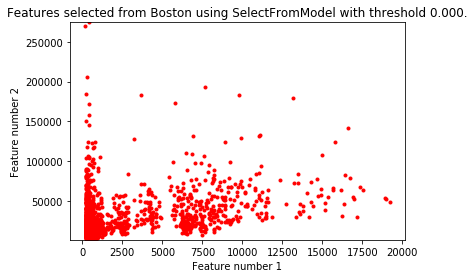

In [0]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_boston
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV


x=np.array(training_set)[:-5]
y=np.array(training_set["CLOSE"][5:])


# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV()

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0)
sfm.fit(x, y)
n_features = sfm.transform(x).shape[1]

# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.
while n_features > 2:
    sfm.threshold += 0.00001
    X_transform = sfm.transform(x)
    n_features = X_transform.shape[1]
print(X_transform.shape)
# Plot the selected two features from X.
plt.title(
    "Features selected from Boston using SelectFromModel with "
    "threshold %0.3f." % sfm.threshold)
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1]
plt.plot(feature1, feature2, 'r.')
plt.xlabel("Feature number 1")
plt.ylabel("Feature number 2")
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()



INFO:tensorflow:Restoring parameters from ./checkpoint_dir\MyModel-1000


In [0]:
actual_change=[]
predict_change=[]
error_index=set()
score=0
change_score=0

reset_LAST_test_set=test_set['CLOSE'].reset_index(drop=1)
pred_price_transform=(pred_result+1)*reset_LAST_test_set[:-window_len+pred_length]

#-----------------------------------------實際漲跌--------------------------------------------------#
actual_label=[]
actual_label.append(reset_LAST_test_set[window_len-1])
actual_label.extend(reset_LAST_test_set[window_len:].tolist())
actual_label=np.array(actual_label)

for i in range(len(actual_label)-1):
    if actual_label[i]-actual_label[i+1]>0:
        actual_change.append(-1)
    elif actual_label[i]-actual_label[i+1]<0:
        actual_change.append(1)
    else:
        actual_change.append(0)
#--------------------------------------------------------------------------------------------#
#---------------------------------------預測漲跌-----------------------------------------------------#
predict_label=[]
predict_label.append(reset_LAST_test_set[window_len-1])
predict_label.extend(pred_price_transform)
predict_label=np.array(predict_label)

for i in range(len(predict_label)-1-pred_length):
    if predict_label[i]-predict_label[i+1]>0:
        predict_change.append(-1)
    elif predict_label[i]-predict_label[i+1]<0:
        predict_change.append(1)
    else:
        predict_change.append(0)
#-------------------------------------------價格差距-------------------------------------------------# 
pred_price=pred_price_transform
actual_price=reset_LAST_test_set[window_len:]
different=[]
for i in range(len(actual_price)):
    different.append((actual_price[i+window_len]-abs(pred_price[i]-actual_price[i+window_len]))/actual_price[i+window_len])

different=np.array(different)
price_score=different.mean()
#-------------------------------------------斜率-------------------------------------------------#        
#actual_slope=[]
#pred_slope=[]
#different_slope=[]
#actual_slope.append(reset_LAST_test_set[window_len]-reset_LAST_test_set[window_len-1])
#pred_slope.append(pred_price_transform[0]-reset_LAST_test_set[window_len-1])
#for i in range(len(pred_result)-1):
#    actual_slope.append(reset_LAST_test_set[window_len+i+1]-reset_LAST_test_set[window_len+i])
#    pred_slope.append(pred_price_transform[i+1]-pred_price_transform[i])

#for j in range(len(actual_slope)):
#    different_slope.append(actual_slope[j]-pred_slope[j])
    

#--------------------------------------------------------------------------------------------#        

#--------------------------------------------------------------------------------------------#        
for k in range(len(actual_change)):
    if predict_change[k]==actual_change[k]:
        change_score+=1
    else:
        if k!=0:
            temp=set([k,k-1])-error_index
            error_index=error_index.union(temp)

change_score=change_score/len(actual_change)
total=change_score+price_score
print(total,change_score,price_score)

1.4381441565393063 0.498220640569395 0.9399235159699112


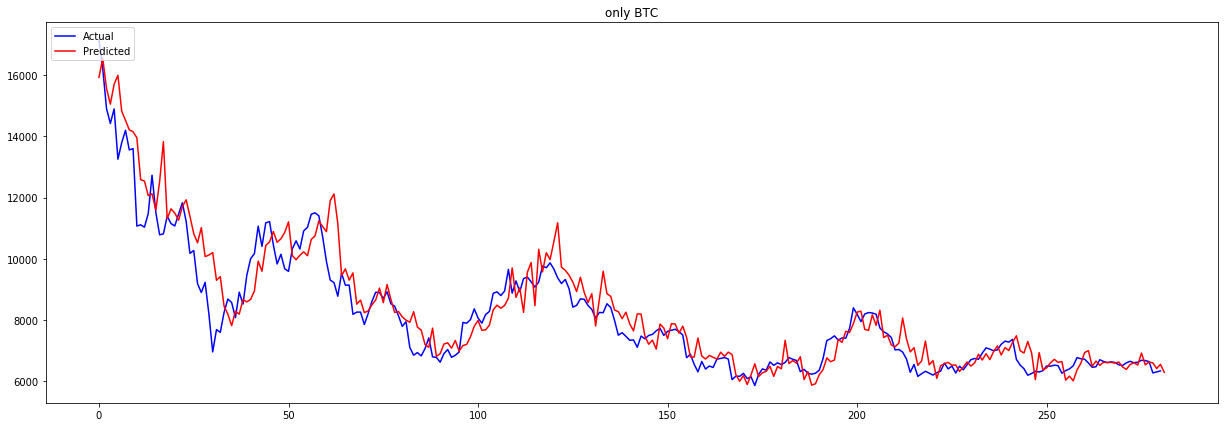

0    15932.702539
1    16552.396777
2    15563.994049
3    15055.437949
4    15708.269749
Name: CLOSE, dtype: float64


In [0]:
error_change=[ pred_price[i] for i in list(error_index)]
plt.figure(figsize=(21,7))
plt.plot(reset_LAST_test_set[window_len:].reset_index(drop=1),label='Actual',color='blue')
plt.plot((pred_result+1)*test_set['CLOSE'].reset_index(drop=1)[:-window_len+pred_length],label='Predicted',color='red')
#plt.plot(list(error_index),error_change,label='Predicted',color='black',linewidth = '0',marker='x')
plt.title("only BTC")
plt.legend(loc='upper left')
plt.show()
print(((pred_result+1)*test_set['CLOSE'].reset_index(drop=1)[:-window_len+pred_length]).iloc[0:5])

In [0]:
actual_change=[]
predict_change=[]
error_index=set()
score=0
change_score=0

reset_LAST_test_set=test_set['CLOSE'].reset_index(drop=1)
pred_price_transform=(pred_result+1)*reset_LAST_test_set[:-window_len+pred_length]

#-----------------------------------------實際漲跌--------------------------------------------------#
actual_label=[]
actual_label.append(reset_LAST_test_set[window_len-1])
actual_label.extend(reset_LAST_test_set[window_len:window_len+5].tolist())
actual_label=np.array(actual_label)

for i in range(len(actual_label)-1):
    if actual_label[i]-actual_label[i+1]>0:
        actual_change.append(-1)
    elif actual_label[i]-actual_label[i+1]<0:
        actual_change.append(1)
    else:
        actual_change.append(0)
#--------------------------------------------------------------------------------------------#
#---------------------------------------預測漲跌-----------------------------------------------------#
predict_label=[]
predict_label.append(reset_LAST_test_set[window_len-1])
predict_label.extend(pred_price_transform[0:5])
predict_label=np.array(predict_label)

for i in range(len(predict_label)-1):
    if predict_label[i]-predict_label[i+1]>0:
        predict_change.append(-1)
    elif predict_label[i]-predict_label[i+1]<0:
        predict_change.append(1)
    else:
        predict_change.append(0)
#-------------------------------------------價格差距-------------------------------------------------# 
pred_price=pred_price_transform[0:5]
actual_price=reset_LAST_test_set[window_len:window_len+5].reset_index(drop=1)
different=[]
for i in range(len(actual_price)):
    different.append((actual_price[i]-abs(pred_price[i]-actual_price[i]))/actual_price[i])

different=np.array(different)
price_score=different.mean()
#-------------------------------------------斜率-------------------------------------------------#        
#actual_slope=[]
#pred_slope=[]
#different_slope=[]
#actual_slope.append(reset_LAST_test_set[window_len]-reset_LAST_test_set[window_len-1])
#pred_slope.append(pred_price_transform[0]-reset_LAST_test_set[window_len-1])
#for i in range(len(pred_result)-1):
#    actual_slope.append(reset_LAST_test_set[window_len+i+1]-reset_LAST_test_set[window_len+i])
#    pred_slope.append(pred_price_transform[i+1]-pred_price_transform[i])

#for j in range(len(actual_slope)):
#    different_slope.append(actual_slope[j]-pred_slope[j])
    

#--------------------------------------------------------------------------------------------#        

#--------------------------------------------------------------------------------------------#     
print(actual_price,pred_price)
for k in range(len(actual_change)):
    if predict_change[k]==actual_change[k]:
        change_score+=1
    else:
        if k!=0:
            temp=set([k,k-1])-error_index
            error_index=error_index.union(temp)

change_score=change_score/len(actual_change)
total=change_score+price_score
print(total,change_score,price_score)

0    6601.9
1    6527.5
2    6503.2
3    6590.4
4    6639.9
Name: CLOSE, dtype: float64 0    6649.267922
1    6567.692849
2    6499.001860
3    6574.633177
4    6513.075164
Name: CLOSE, dtype: float64
1.592905857437433 0.6 0.9929058574374331


In [0]:
actual_change=[]
predict_change=[]
error_index=set()
score=0
change_score=0
coin="BTC"
reset_LAST_test_set=test_set[coin+'_LAST'].reset_index(drop=1)
pred_price_transform=(pred_result+1)*reset_LAST_test_set[:-window_len]

#-----------------------------------------實際漲跌--------------------------------------------------#
actual_label=[]
actual_label.append(reset_LAST_test_set[window_len-1])
actual_label.extend(reset_LAST_test_set[window_len:].tolist())
actual_label=np.array(actual_label)

for i in range(len(actual_label)-1):
    if actual_label[i]-actual_label[i+1]>0:
        actual_change.append(-1)
    elif actual_label[i]-actual_label[i+1]<0:
        actual_change.append(1)
    else:
        actual_change.append(0)
#--------------------------------------------------------------------------------------------#
#---------------------------------------預測漲跌-----------------------------------------------------#
predict_label=[]
predict_label.append(reset_LAST_test_set[window_len-1])
predict_label.extend(pred_price_transform)
predict_label=np.array(predict_label)

for i in range(len(predict_label)-1):
    if predict_label[i]-predict_label[i+1]>0:
        predict_change.append(-1)
    elif predict_label[i]-predict_label[i+1]<0:
        predict_change.append(1)
    else:
        predict_change.append(0)
#-------------------------------------------價格差距-------------------------------------------------# 
pred_price=pred_price_transform
actual_price=reset_LAST_test_set[window_len:]
different=[]
for i in range(len(actual_price)):
    different.append((actual_price[i+window_len]-abs(pred_price[i]-actual_price[i+window_len]))/actual_price[i+window_len])

different=np.array(different)
price_score=different.mean()*0.5
#-------------------------------------------斜率-------------------------------------------------#        
actual_slope=[]
pred_slope=[]
different_slope=[]
actual_slope.append(reset_LAST_test_set[window_len]-reset_LAST_test_set[window_len-1])
pred_slope.append(pred_price_transform[0]-reset_LAST_test_set[window_len-1])
for i in range(len(pred_result)-1):
    actual_slope.append(reset_LAST_test_set[window_len+i+1]-reset_LAST_test_set[window_len+i])
    pred_slope.append(pred_price_transform[i+1]-pred_price_transform[i])

for j in range(len(actual_slope)):
    different_slope.append(actual_slope[j]-pred_slope[j])
    

#--------------------------------------------------------------------------------------------#        

#--------------------------------------------------------------------------------------------#        
for k in range(len(actual_change)):
    if predict_change[k]==actual_change[k]:
        change_score+=1
    else:
        if k!=0:
            temp=set([k,k-1])-error_index
            error_index=error_index.union(temp)

change_score=change_score/len(actual_change)*0.5
total=change_score+price_score
print(total,change_score,price_score)

0.7816561918084297 0.29411764705882354 0.48753854474960623
